In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder
from collections import Counter
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from scipy import stats
from statsmodels.stats.diagnostic import het_breuschpagan, acorr_ljungbox
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.stattools import jarque_bera
from statsmodels.stats.diagnostic import het_goldfeldquandt


In [ ]:
df = pd.read_csv('E:/UIT/Nam-2/Ki-2/Predicting-Popularity-of-Vietnamese-Articles/2. Data Pre-processing/dataset3.csv')

In [ ]:
df['popularity_score'] = (0.1 * df['comments'] + 0.1 * df['interactions'] ) / (df['time_since_posted'] + 1e-10)
df.drop(columns=['time_since_posted'], inplace=True)

In [ ]:
df.columns

Index(['title', 'date', 'wordcount', 'comments', 'interactions', 'images',
       'videos', 'tags', 'category', 'popularity_score', 'title_length',
       'has_number', 'has_emotion', 'is_question', 'title_score',
       'sentiment_score', 'negative', 'neutral', 'posted_hour', 'is_weekday',
       'classified_tags', 'has_famous_people_tag', 'has_place_tag',
       'has_event_tag', 'has_org_tag', 'has_comments', 'has_interactions'],
      dtype='object')

In [ ]:
num_cols = ['wordcount', 'images', 'title_length',
       'videos', 'title_score', 'sentiment_score', 'positive', 'negative', 'neutral','popularity_score']

In [ ]:
cat_cols = ['has_number', 'has_emotion', 'is_question',
            'posted_hour','is_weekday', 'has_famous_people_tag',
            'has_place_tag', 'has_event_tag', 'has_org_tag', 'has_comments',
            'has_interactions','popularity_score' ]

In [ ]:
df_num = df[num_cols].copy()

In [ ]:
df_cat = df[cat_cols].copy()

In [ ]:
X_num = df_num.drop(columns = 'popularity_score')
y_num = df_num['popularity_score']

Filter-based(Trước encode): Correlation Coefficient, Mutual Info
Embeddef-based(Sau khi encode): Feature Importance

###Correlation Coefficient (Pearson)###

Tương quan Pearson với biến mục tiêu:
 title_score        0.356939
negative           0.102101
wordcount          0.072940
images             0.050012
videos             0.039533
title_length       0.029952
neutral           -0.022716
positive          -0.084943
sentiment_score   -0.106390
Name: popularity_score, dtype: float64


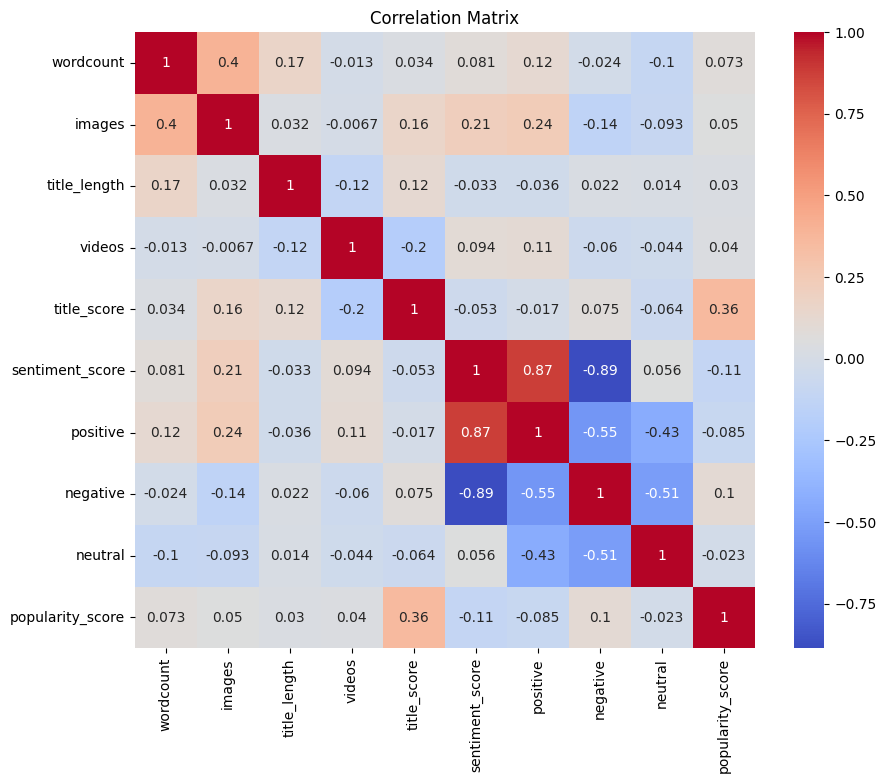

In [ ]:
# Tính tương quan với biến mục tiêu
X_num['popularity_score'] = y_num
corr_with_target = X_num.corr()['popularity_score'].drop('popularity_score')

# In ra tương quan
print("Tương quan Pearson với biến mục tiêu:\n", corr_with_target.sort_values(ascending=False))

# Vẽ heatmap cho ma trận tương quan
plt.figure(figsize=(10, 8))
sns.heatmap(X_num.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [ ]:
df = df.drop(columns = 'positive')

### Code xử lý tags

In [ ]:
df_train, df_temp = train_test_split(df, test_size=0.3, random_state=42)
df_dev, df_test = train_test_split(df_temp, test_size=0.5, random_state=42)

In [ ]:

# Normalize tag: replace spaces with underscores
def normalize_tag(tag: str) -> str:
    return tag.replace(' ', '_')

# Create tag_text for each set
def tags_to_doc(cat_dict, frequent_tag_set=None):
    if frequent_tag_set:
        return ' '.join(
            normalize_tag(tag)
            for tags in cat_dict.values()
            for tag in tags
            if normalize_tag(tag) in frequent_tag_set
        )
    return ' '.join(
        normalize_tag(tag)
        for tags in cat_dict.values()
        for tag in tags
    )

# Safe evaluation of string to dictionary
def safe_eval(x):
    if isinstance(x, dict):
        return x
    if isinstance(x, str):
        try:
            return ast.literal_eval(x)
        except (ValueError, SyntaxError):
            return {}
    return {}

In [ ]:
# Apply safe_eval to classified_tags
df_train['classified_tags'] = df_train['classified_tags'].apply(safe_eval)
df_dev['classified_tags'] = df_dev['classified_tags'].apply(safe_eval)
df_test['classified_tags'] = df_test['classified_tags'].apply(safe_eval)

# 1. Find frequent tags only on train set
all_tags_train = []
for row in df_train['classified_tags']:
    for tags in row.values():
        all_tags_train.extend([normalize_tag(tag) for tag in tags])

k = 5
tag_counts = Counter(all_tags_train)
frequent_tags = [tag for tag, count in tag_counts.items() if count >= k]
frequent_tags_set = set(frequent_tags)

In [ ]:
df_train['classified_tags'] = df_train['classified_tags'].apply(safe_eval)
print(df_train['classified_tags'].map(type).value_counts())

classified_tags
<class 'dict'>    3717
Name: count, dtype: int64


In [ ]:
# 2. Create tag_text for train/dev/test, keeping only frequent tags
df_train['tag_text'] = df_train['classified_tags'].apply(lambda x: tags_to_doc(x, frequent_tags_set))
df_dev['tag_text'] = df_dev['classified_tags'].apply(lambda x: tags_to_doc(x, frequent_tags_set))
df_test['tag_text'] = df_test['classified_tags'].apply(lambda x: tags_to_doc(x, frequent_tags_set))

# 3. Fit TF-IDF on train and transform on dev/test
vectorizer = TfidfVectorizer(vocabulary=frequent_tags)
X_train_tfidf = vectorizer.fit_transform(df_train['tag_text'])
X_dev_tfidf = vectorizer.transform(df_dev['tag_text'])
X_test_tfidf = vectorizer.transform(df_test['tag_text'])

/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:1368: UserWarning: Upper case characters found in vocabulary while 'lowercase' is True. These entries will not be matched with any documents
  warnings.warn(


### One hot + Standard_Scaled

In [ ]:
y_train = df_train['popularity_score']
X_train = df_train.drop(columns=['title','date','popularity_score','comments', 'interactions', 'tags', 'classified_tags', 'tag_text'])

y_test = df_test['popularity_score']
X_test = df_test.drop(columns=['title','date','popularity_score','comments', 'interactions', 'tags', 'classified_tags', 'tag_text'])

y_dev = df_dev['popularity_score']
X_dev = df_dev.drop(columns=['title','date','popularity_score','comments', 'interactions', 'tags', 'classified_tags', 'tag_text'])

In [ ]:
categorical_cols = ['category', 'posted_hour', 'has_comments', 'has_interactions', 'has_number',
                   'has_emotion', 'is_question','has_famous_people_tag', 'has_place_tag', 'has_event_tag',
                   'has_org_tag', 'is_weekday'
    ]

# Loại trừ các cột cols_to_exclude ra khỏi tập chuẩn hóa
X_train_to_scale = X_train.drop(columns=categorical_cols)
X_dev_to_scale = X_dev.drop(columns=categorical_cols)
X_test_to_scale = X_test.drop(columns=categorical_cols)

# Chuẩn hóa
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_to_scale),
                             columns=X_train_to_scale.columns,
                             index=X_train_to_scale.index)
X_dev_scaled = pd.DataFrame(scaler.transform(X_dev_to_scale),
                           columns=X_dev_to_scale.columns,
                           index=X_dev_to_scale.index)
X_test_scaled = pd.DataFrame(scaler.transform(X_test_to_scale),
                            columns=X_test_to_scale.columns,
                            index=X_test_to_scale.index)

# Gộp lại với các cột đã loại trừ
X_train_scaled = pd.concat([X_train_scaled, X_train[categorical_cols]], axis=1)
X_dev_scaled = pd.concat([X_dev_scaled, X_dev[categorical_cols]], axis=1)
X_test_scaled = pd.concat([X_test_scaled, X_test[categorical_cols]], axis=1)

In [ ]:
print("Columns in X_train:", X_train.columns.tolist())
print("Columns in X_dev:", X_dev.columns.tolist())
print("Columns in X_test:", X_test.columns.tolist())
print("Columns in X_train_scaled:", X_train_scaled.columns.tolist())
print("Columns in X_dev_scaled:", X_dev_scaled.columns.tolist())
print("Columns in X_test_scaled:", X_test_scaled.columns.tolist())

if categorical_cols:
    print("Cột phân loại cần mã hóa:", categorical_cols)
    # Tạo OneHotEncoder
    onehot_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

    # Mã hóa cột phân loại cho train
    categorical_encoded = onehot_encoder.fit_transform(X_train_scaled[categorical_cols])
    categorical_columns = onehot_encoder.get_feature_names_out(categorical_cols)
    categorical_df = pd.DataFrame(categorical_encoded, columns=categorical_columns, index=X_train_scaled.index)

    # Loại bỏ cột phân loại gốc và gộp với dữ liệu mã hóa
    X_train_scaled = X_train_scaled.drop(columns=categorical_cols, errors='ignore')
    X_train_scaled = pd.concat([X_train_scaled, categorical_df], axis=1)

    # Tương tự cho dev
    categorical_encoded_dev = onehot_encoder.transform(X_dev_scaled[categorical_cols])
    categorical_df_dev = pd.DataFrame(categorical_encoded_dev, columns=categorical_columns, index=X_dev_scaled.index)
    X_dev_scaled = X_dev_scaled.drop(columns=categorical_cols, errors='ignore')
    X_dev_scaled = pd.concat([X_dev_scaled, categorical_df_dev], axis=1)

    # Tương tự cho test
    categorical_encoded_test = onehot_encoder.transform(X_test_scaled[categorical_cols])
    categorical_df_test = pd.DataFrame(categorical_encoded_test, columns=categorical_columns, index=X_test_scaled.index)
    X_test_scaled = X_test_scaled.drop(columns=categorical_cols, errors='ignore')
    X_test_scaled = pd.concat([X_test_scaled, categorical_df_test], axis=1)
else:
    print("Không có cột phân loại cần mã hóa.")

# Kiểm tra shape sau khi mã hóa
print("Shape X_train_scaled:", X_train_scaled.shape)
print("Shape X_dev_scaled:", X_dev_scaled.shape)
print("Shape X_test_scaled:", X_test_scaled.shape)

Columns in X_train: ['wordcount', 'images', 'videos', 'category', 'title_length', 'has_number', 'has_emotion', 'is_question', 'title_score', 'sentiment_score', 'negative', 'neutral', 'posted_hour', 'is_weekday', 'has_famous_people_tag', 'has_place_tag', 'has_event_tag', 'has_org_tag', 'has_comments', 'has_interactions']
Columns in X_dev: ['wordcount', 'images', 'videos', 'category', 'title_length', 'has_number', 'has_emotion', 'is_question', 'title_score', 'sentiment_score', 'negative', 'neutral', 'posted_hour', 'is_weekday', 'has_famous_people_tag', 'has_place_tag', 'has_event_tag', 'has_org_tag', 'has_comments', 'has_interactions']
Columns in X_test: ['wordcount', 'images', 'videos', 'category', 'title_length', 'has_number', 'has_emotion', 'is_question', 'title_score', 'sentiment_score', 'negative', 'neutral', 'posted_hour', 'is_weekday', 'has_famous_people_tag', 'has_place_tag', 'has_event_tag', 'has_org_tag', 'has_comments', 'has_interactions']
Columns in X_train_scaled: ['wordcoun

In [ ]:
from scipy.sparse import hstack, csr_matrix
import numpy as np

# Chuyển đổi DataFrame thành sparse matrix
X_train_scaled_transform = X_train_scaled.apply(pd.to_numeric)
X_dev_scaled_transform = X_dev_scaled.apply(pd.to_numeric)
X_test_scaled_transform = X_test_scaled.apply(pd.to_numeric)

X_train_scaled_sparse = csr_matrix(X_train_scaled_transform.values)
X_dev_scaled_sparse = csr_matrix(X_dev_scaled_transform.values)
X_test_scaled_sparse = csr_matrix(X_test_scaled_transform.values)

# Kết hợp dữ liệu
X_train_combined = hstack([X_train_tfidf, X_train_scaled_sparse])
X_dev_combined = hstack([X_dev_tfidf, X_dev_scaled_sparse])
X_test_combined = hstack([X_test_tfidf, X_test_scaled_sparse])

# In thông tin để kiểm tra
print("Shape của X_train_combined:", X_train_combined.shape)
print("Shape của X_dev_combined:", X_dev_combined.shape)
print("Shape của X_test_combined:", X_test_combined.shape)

Shape của X_train_combined: (3717, 437)
Shape của X_dev_combined: (796, 437)
Shape của X_test_combined: (797, 437)


### Chỉ thực hiện MI trên tập scaled và chưa transform thành matrix

In [ ]:
# 11. Tạo feature_names
# existing_feature_names = X_train_scaled_transform.columns.tolist()
# tfidf_feature_names = [f'tfidf_{tag}' for tag in vectorizer.get_feature_names_out()]
feature_names = X_train_scaled.columns.tolist()

In [ ]:
from sklearn.feature_selection import SelectKBest, mutual_info_regression
y_train = np.ravel(y_train)  # Đảm bảo y là 1D

selector = SelectKBest(score_func=mutual_info_regression, k=20)
X_selected = selector.fit_transform(X_train_scaled, y_train)

# Xem điểm MI
scores = pd.DataFrame({
    "Đặc trưng": feature_names,
    "Điểm MI": selector.scores_
}).sort_values(by="Điểm MI", ascending=False)

In [ ]:
print("Top 5 đặc trưng theo MI:")
print(scores.head())

# Lấy tên các đặc trưng được chọn
selected_features = np.array(feature_names)[selector.get_support()]
print("\nCác đặc trưng được chọn:", selected_features)

Top 5 đặc trưng theo MI:
             Đặc trưng   Điểm MI
44  has_interactions_1  0.520752
41      has_comments_0  0.515832
42      has_comments_1  0.504392
43  has_interactions_0  0.502469
4          title_score  0.128648

Các đặc trưng được chọn: ['wordcount' 'title_length' 'title_score' 'negative' 'category_1'
 'category_2' 'category_6' 'category_7' 'category_8' 'category_9'
 'posted_hour_6' 'posted_hour_16' 'has_comments_0' 'has_comments_1'
 'has_interactions_0' 'has_interactions_1' 'has_emotion_1'
 'has_event_tag_True' 'is_weekday_0' 'is_weekday_1']


In [ ]:
print("Các đặc trưng có độ dự đoán thấp theo MI:")
print(scores.tail(20))

Các đặc trưng có độ dự đoán thấp theo MI:
              Đặc trưng   Điểm MI
19        posted_hour_2  0.000397
5       sentiment_score  0.000000
1                images  0.000000
11           category_4  0.000000
28       posted_hour_11  0.000000
26        posted_hour_9  0.000000
25        posted_hour_8  0.000000
24        posted_hour_7  0.000000
17        posted_hour_0  0.000000
20        posted_hour_3  0.000000
7               neutral  0.000000
36       posted_hour_19  0.000000
29       posted_hour_12  0.000000
30       posted_hour_13  0.000000
35       posted_hour_18  0.000000
46         has_number_1  0.000000
50        is_question_1  0.000000
45         has_number_0  0.000000
55  has_event_tag_False  0.000000
53  has_place_tag_False  0.000000


In [ ]:
# Danh sách các cột cần kiểm tra
cols_to_check = ['has_number_1', 'is_question_0', 'has_event_tag_False', 'neutral']

# Kiểm tra số giá trị duy nhất của mỗi biến
print("🔍 Số giá trị duy nhất của mỗi biến:")
for col in cols_to_check:
    if col in X_train_scaled.columns:
        unique_vals = X_train_scaled[col].nunique()
        print(f"{col}: {unique_vals} giá trị")
    else:
        print(f"⚠️ Cột {col} không có trong X_train_scaled")

print("\n Tần suất xuất hiện của từng giá trị:")
for col in cols_to_check:
    if col in X_train_scaled.columns:
        print(f"\nBiến: {col}")
        print(X_train_scaled[col].value_counts(dropna=False))


🔍 Số giá trị duy nhất của mỗi biến:
has_number_1: 2 giá trị
is_question_0: 2 giá trị
has_event_tag_False: 2 giá trị
neutral: 3715 giá trị

 Tần suất xuất hiện của từng giá trị:

Biến: has_number_1
has_number_1
0.0    2583
1.0    1134
Name: count, dtype: int64

Biến: is_question_0
is_question_0
1.0    3426
0.0     291
Name: count, dtype: int64

Biến: has_event_tag_False
has_event_tag_False
1.0    3177
0.0     540
Name: count, dtype: int64

Biến: neutral
neutral
 1.367053    2
 1.365384    2
-1.181051    1
-0.806657    1
 1.417916    1
            ..
 0.886918    1
-1.195000    1
-0.312870    1
-1.159529    1
-1.194622    1
Name: count, Length: 3715, dtype: int64


Không cần thiết phải xóa các biến này do có nhiều giá trị khác nhau & phân bố của các giá trị không quá lệch

### Feature Importance trên tập chỉ có biến phân loại và số ##

In [ ]:
# Huấn luyện mô hình Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train_scaled, y_train)

# Lấy điểm tầm quan trọng
importances = rf.feature_importances_
feature_importance_rf = pd.DataFrame({
    'Đặc trưng': feature_names,
    'Tầm quan trọng': importances
})

In [ ]:
# Hiển thị top 5 đặc trưng
display("\nTầm quan trọng của đặc trưng (Random Forest):\n", feature_importance_rf.sort_values(by='Tầm quan trọng', ascending=False).tail(20))

'\nTầm quan trọng của đặc trưng (Random Forest):\n'

,Đặc trưng,Tầm quan trọng
58,has_org_tag_True,0.003001
50,is_question_1,0.002893
48,has_emotion_1,0.002870
22,posted_hour_5,0.002753
10,category_3,0.002662
35,posted_hour_18,0.002644
31,posted_hour_14,0.002631
12,category_5,0.002573
47,has_emotion_0,0.002533
40,posted_hour_23,0.002297


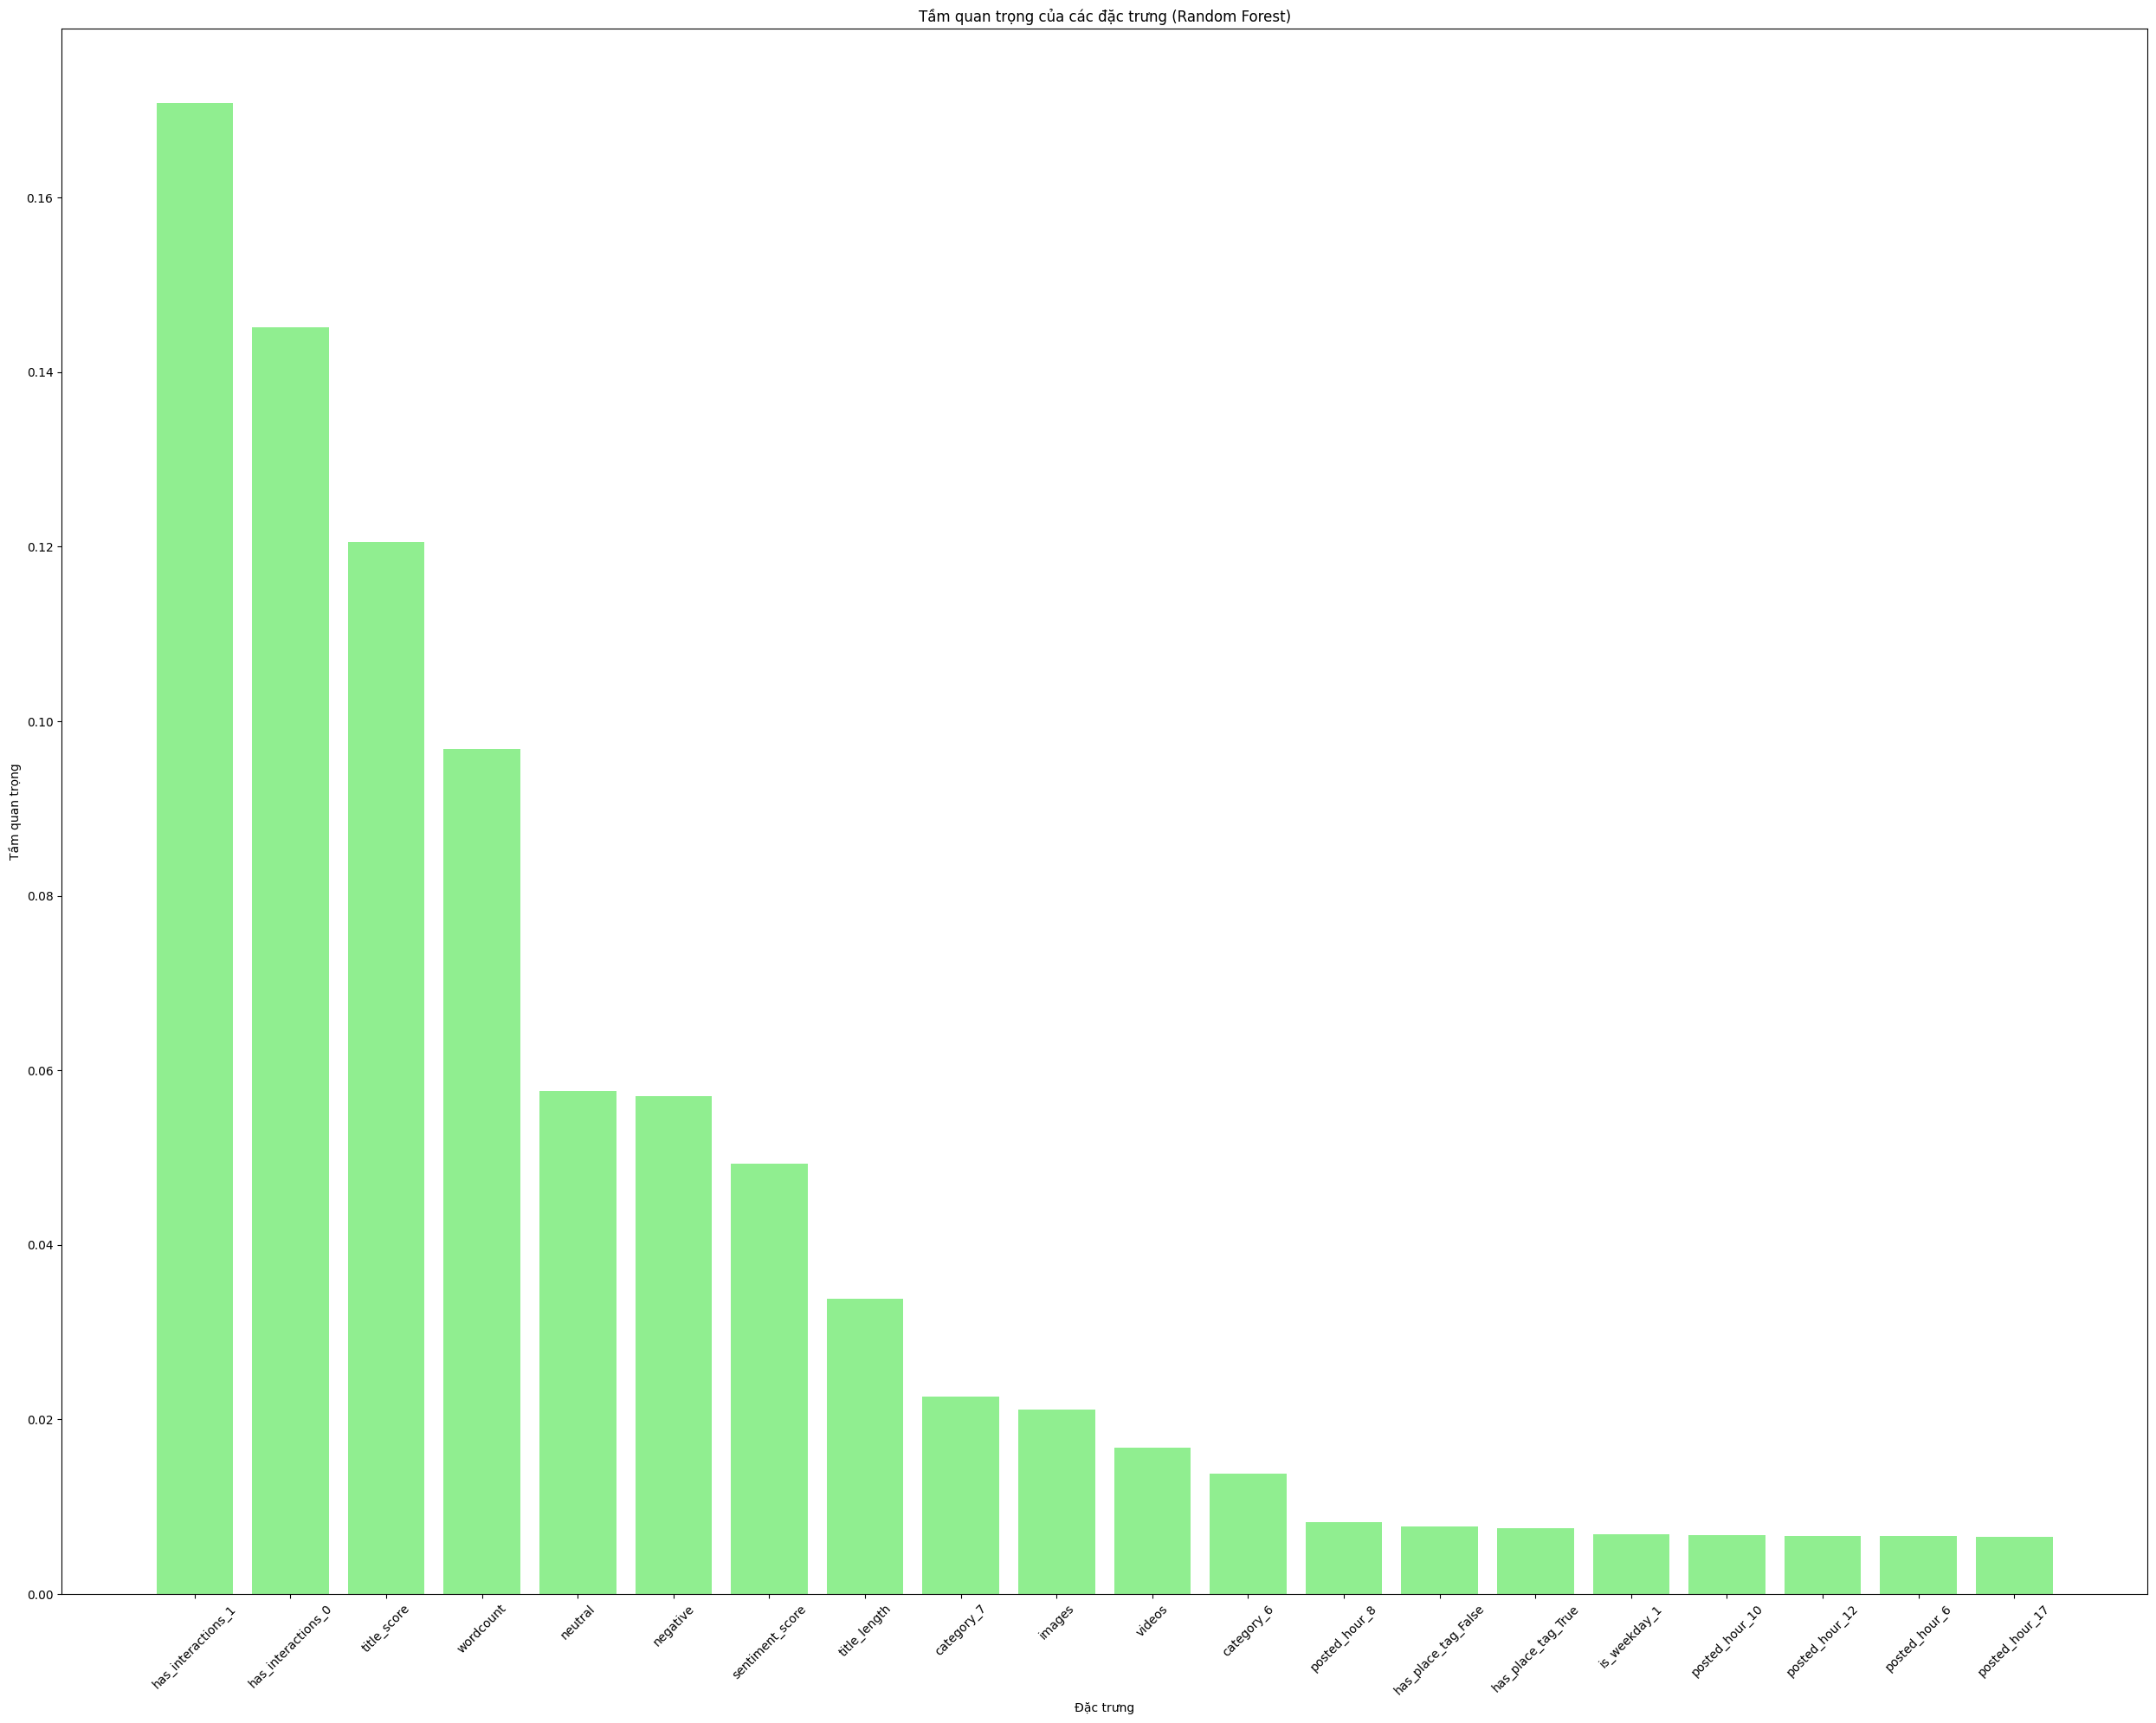

In [ ]:
# Vẽ biểu đồ
plt.figure(figsize=(25, 20))
top_rf = feature_importance_rf.sort_values(by='Tầm quan trọng', ascending=False).head(20)
plt.bar(top_rf['Đặc trưng'], top_rf['Tầm quan trọng'], color='lightgreen')
plt.xticks(rotation=45)
plt.xlabel('Đặc trưng')
plt.ylabel('Tầm quan trọng')
plt.title('Tầm quan trọng của các đặc trưng (Random Forest)')
plt.tight_layout()
plt.show()

### Feature Importance có bao gồm các TF-IDF Vector

In [ ]:
# 11. Tạo feature_names mới
existing_feature_names = X_train_scaled_transform.columns.tolist()
tfidf_feature_names = [f'tfidf_{tag}' for tag in vectorizer.get_feature_names_out()]
feature_names1 = existing_feature_names + tfidf_feature_names

In [ ]:
# Huấn luyện mô hình Random Forest
rf1 = RandomForestRegressor(n_estimators=100, random_state=42)
rf1.fit(X_train_combined, y_train)

# Lấy điểm tầm quan trọng
importances1 = rf1.feature_importances_
feature_importance_rf1 = pd.DataFrame({
    'Đặc trưng': feature_names1,
    'Tầm quan trọng': importances1
})

In [ ]:
# Hiển thị top 5 đặc trưng
display("\nTầm quan trọng của đặc trưng (Random Forest):\n", feature_importance_rf1.sort_values(by='Tầm quan trọng', ascending=False).tail(100))


'\nTầm quan trọng của đặc trưng (Random Forest):\n'

,Đặc trưng,Tầm quan trọng
42,has_comments_1,0.0
36,posted_hour_19,0.0
29,posted_hour_12,0.0
140,tfidf_học_phí_đại_học,0.0
141,tfidf_Tuyển_sinh_đại_học,0.0
...,...,...
200,tfidf_Lừa_đảo_chiếm_đoạt_tài_sản,0.0
201,tfidf_Hòa_Minzy,0.0
202,tfidf_Bắc_Bling,0.0
203,tfidf_Sao_Hoa_ngữ,0.0


In [ ]:
# Hiển thị top 5 đặc trưng
display("\nTầm quan trọng của đặc trưng (Random Forest):\n", feature_importance_rf1.sort_values(by='Tầm quan trọng', ascending=False).head(10))

'\nTầm quan trọng của đặc trưng (Random Forest):\n'

,Đặc trưng,Tầm quan trọng
420,tfidf_Đại_học_Bách_Khoa_TP_HCM,0.186752
419,tfidf_AI_Trung_Quốc,0.129218
380,tfidf_Điện_mặt_trời,0.117017
376,tfidf_Carlo_Ancelotti,0.091493
383,tfidf_Sởi,0.054266
382,tfidf_Tiểu_hành_tinh,0.051394
381,tfidf_Hacker,0.047218
379,tfidf_bán_dẫn,0.032830
390,tfidf_bệnh_thận,0.022607
377,tfidf_Tesla,0.021236


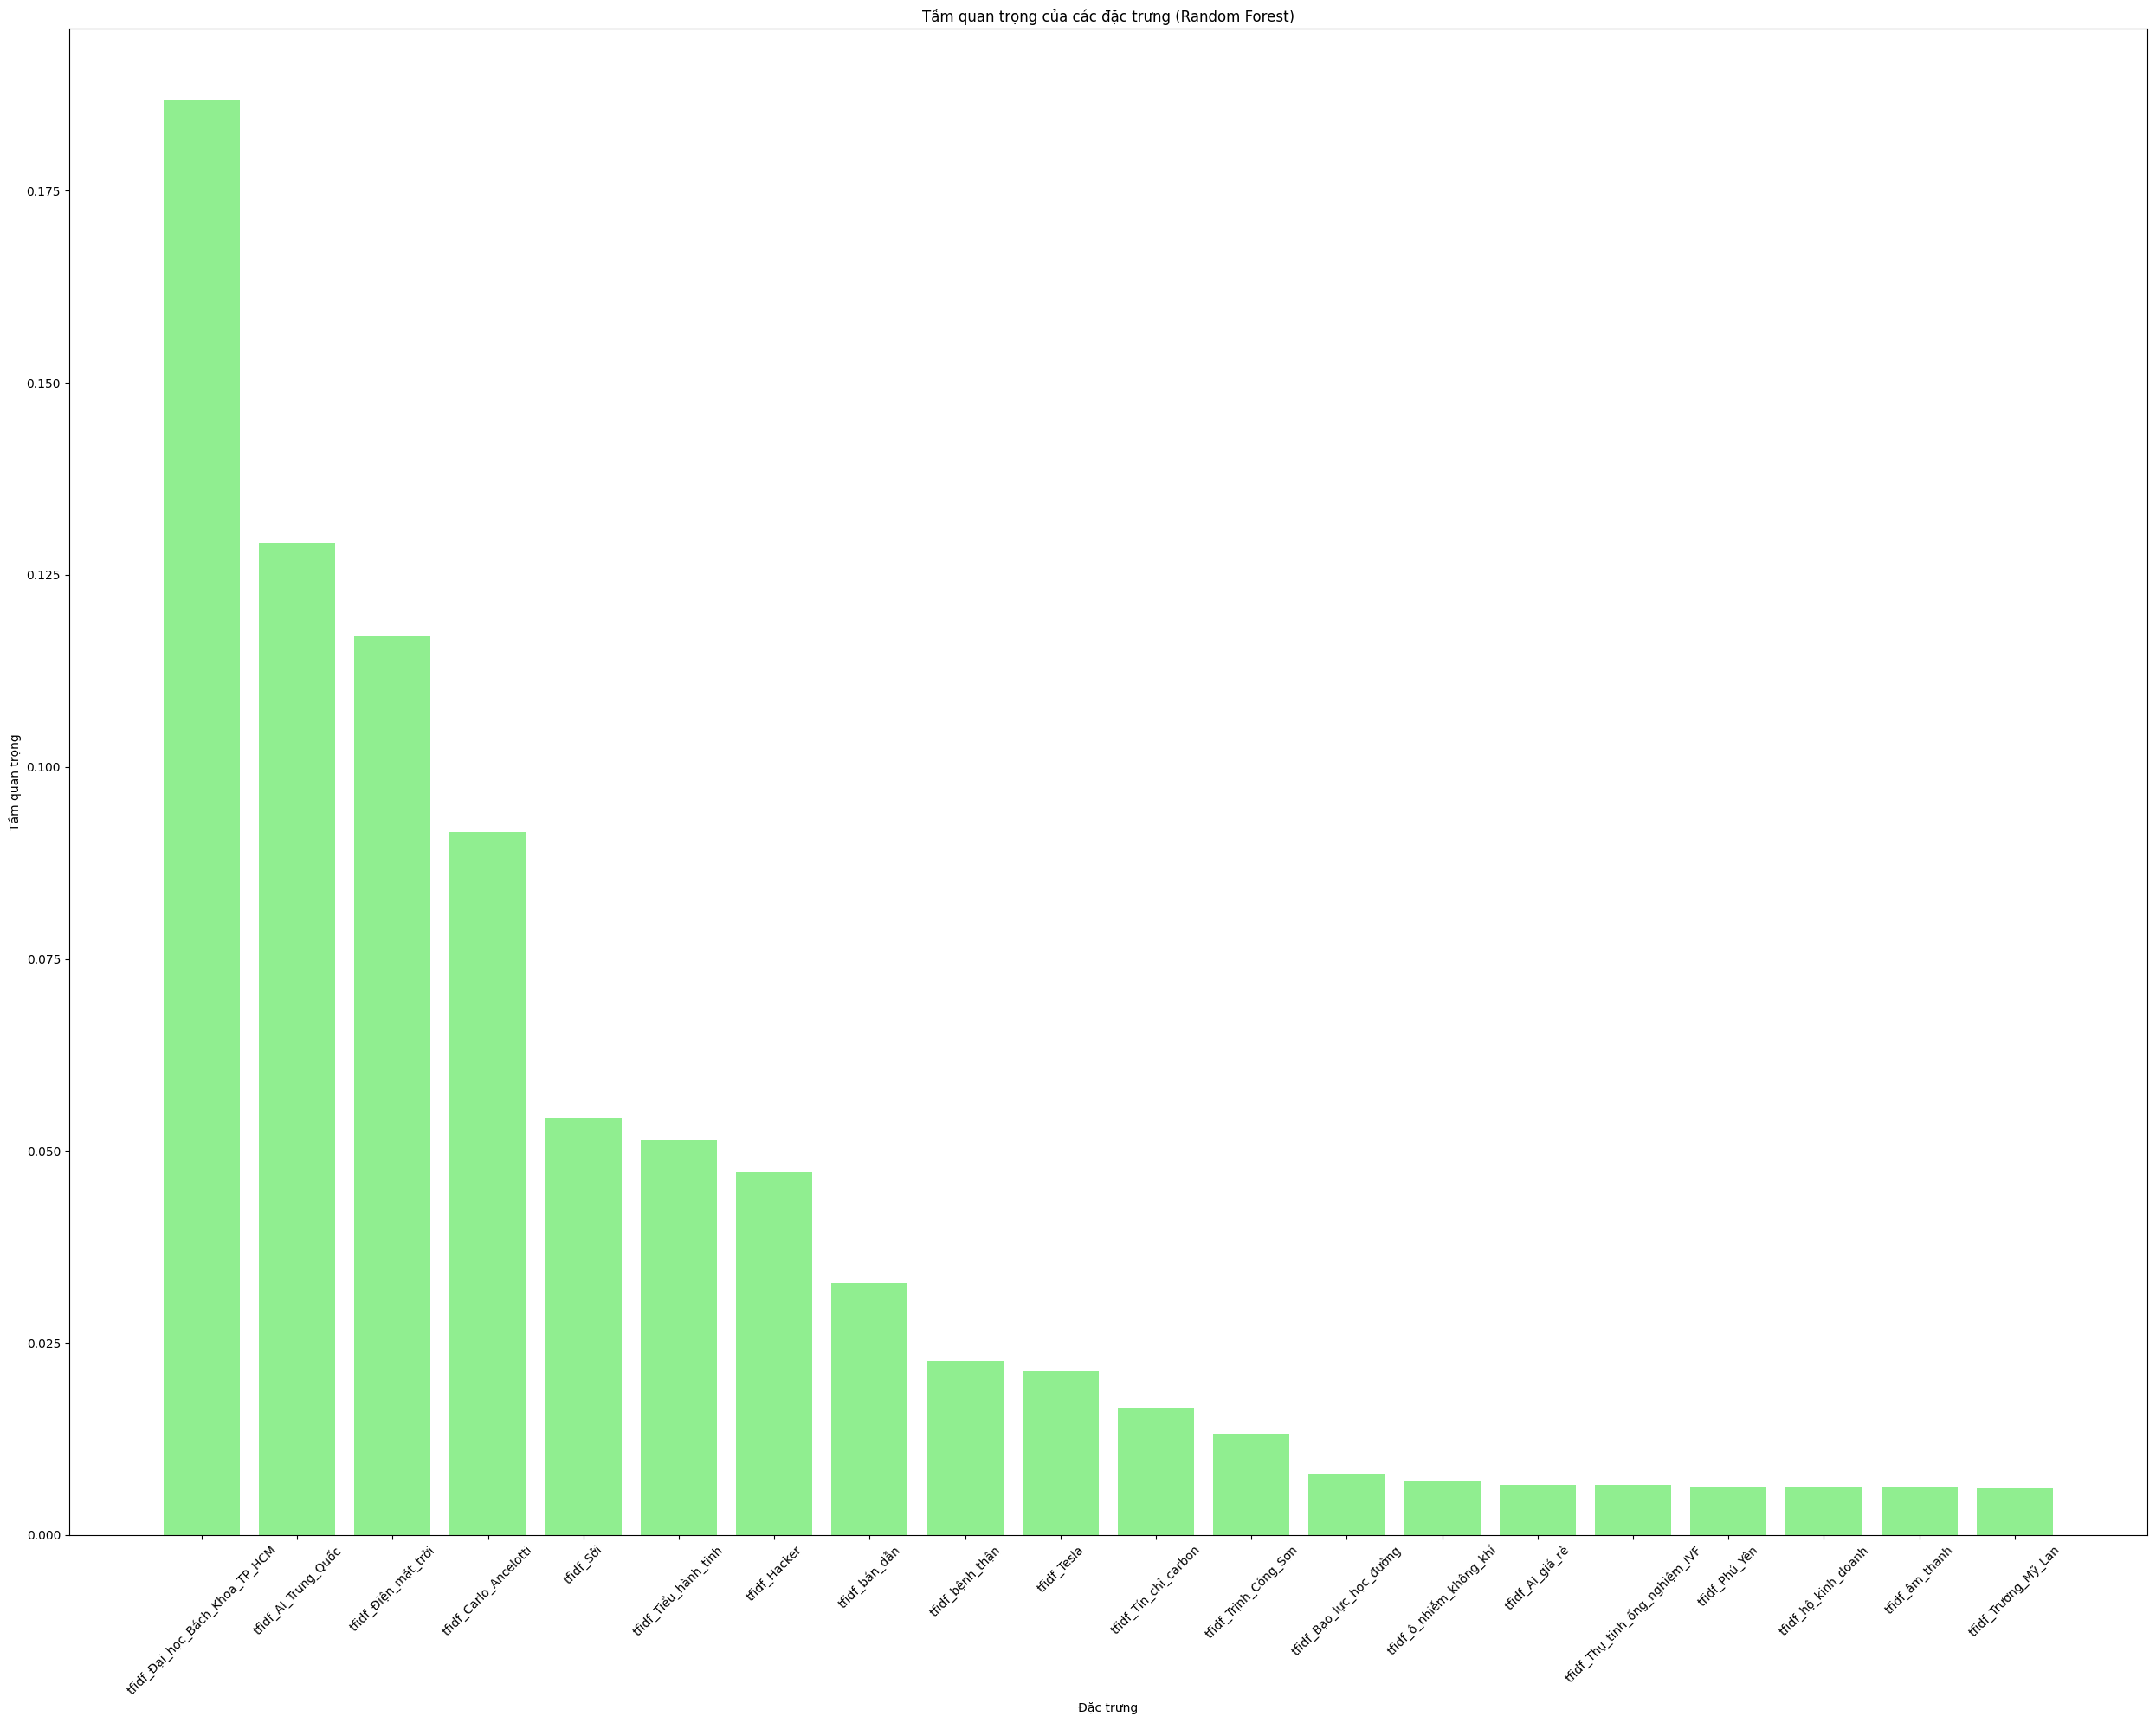

In [ ]:
# Vẽ biểu đồ
plt.figure(figsize=(25, 20))
top_rf = feature_importance_rf1.sort_values(by='Tầm quan trọng', ascending=False).head(20)
plt.bar(top_rf['Đặc trưng'], top_rf['Tầm quan trọng'], color='lightgreen')
plt.xticks(rotation=45)
plt.xlabel('Đặc trưng')
plt.ylabel('Tầm quan trọng')
plt.title('Tầm quan trọng của các đặc trưng (Random Forest)')
plt.tight_layout()
plt.show()

In [ ]:
low_fi_words = feature_importance_rf1[(feature_importance_rf1['Tầm quan trọng'] == 0) & (feature_importance_rf1['Đặc trưng'].str.startswith('tfidf_'))]['Đặc trưng'].tolist()

print("Tổng số đặc trưng có FI = 0 trong TF-IDF:", len(low_fi_words))

Tổng số đặc trưng có FI = 0 trong TF-IDF: 230


In [ ]:
last_100 = low_fi_words[-100:]

In [ ]:
# Chuyển từ sparse matrix sang DataFrame
X_train_df = pd.DataFrame(X_train_combined.toarray(), columns=feature_names1)
X_dev_df   = pd.DataFrame(X_dev_combined.toarray(),   columns=feature_names1)
X_test_df  = pd.DataFrame(X_test_combined.toarray(),  columns=feature_names1)

# Xóa các TF-IDF features không quan trọng
X_train_pruned = X_train_df.drop(columns=last_100)
X_dev_pruned   = X_dev_df.drop(columns=last_100)
X_test_pruned  = X_test_df.drop(columns=last_100)

In [ ]:
# In thông tin để kiểm tra
print("Shape của X_train_df:", X_train_df.shape)
print("Shape của X_dev_df:", X_dev_df.shape)
print("Shape của X_test_df:", X_test_df.shape)

# In thông tin để kiểm tra
print("Shape của X_train_pruned:", X_train_pruned.shape)
print("Shape của X_dev_pruned:", X_dev_pruned.shape)
print("Shape của X_test_pruned:", X_test_pruned.shape)

Shape của X_train_df: (3717, 437)
Shape của X_dev_df: (796, 437)
Shape của X_test_df: (797, 437)
Shape của X_train_pruned: (3717, 337)
Shape của X_dev_pruned: (796, 337)
Shape của X_test_pruned: (797, 337)


### VIF

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Tính VIF
vif_df = pd.DataFrame()
vif_df['feature'] = X_train_pruned.columns
vif_df['VIF'] = [variance_inflation_factor(X_train_pruned.values, i) for i in range(X_train_pruned.shape[1])]
print(vif_df)

/usr/local/lib/python3.11/dist-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/usr/local/lib/python3.11/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


                   feature       VIF
0                wordcount       NaN
1                   images       NaN
2                   videos  1.174844
3             title_length       NaN
4              title_score       NaN
..                     ...       ...
332  tfidf_trường_quân_đội       inf
333    tfidf_Xuất_tinh_sớm       inf
334           tfidf_NVIDIA       inf
335        tfidf_AI_giá_rẻ       inf
336    tfidf_hộ_kinh_doanh       inf

[337 rows x 2 columns]


In [ ]:
print("\nBiến có VIF = inf:")
print(vif_df[(vif_df["VIF"] > 5)])


Biến có VIF = inf:
                           feature        VIF
62          tfidf_Dự_báo_thời_tiết   6.772138
64           tfidf_Bảo_hiểm_xã_hội   6.728447
96   tfidf_Đại_học_Quốc_Gia_Hà_Nội   7.954822
98   tfidf_tuyển_sinh_đại_học_2025   8.663784
280            tfidf_Điện_mặt_trời  10.241269
..                             ...        ...
332          tfidf_trường_quân_đội        inf
333            tfidf_Xuất_tinh_sớm        inf
334                   tfidf_NVIDIA        inf
335                tfidf_AI_giá_rẻ        inf
336            tfidf_hộ_kinh_doanh        inf

[61 rows x 2 columns]


In [ ]:
vif_words = vif_df[(vif_df['VIF'] > 5) & (vif_df['feature'].str.startswith('tfidf_'))]['feature'].tolist()

print("Tổng số đặc trưng có VIF > 5 trong TF-IDF:", len(vif_words))

Tổng số đặc trưng có VIF > 5 trong TF-IDF: 61


In [ ]:
# Xóa các TF-IDF features không quan trọng
X_train_final= X_train_pruned.drop(columns=vif_words)
X_dev_final   = X_dev_pruned.drop(columns=vif_words)
X_test_final  = X_test_pruned.drop(columns=vif_words)

In [ ]:
# In thông tin để kiểm tra
print("Shape của X_train_final:", X_train_final.shape)
print("Shape của X_dev_final:", X_dev_final.shape)
print("Shape của X_test_final:", X_test_final.shape)

Shape của X_train_final: (3717, 276)
Shape của X_dev_final: (796, 276)
Shape của X_test_final: (797, 276)


### Sử dụng kfold kết hợp train-dev-test, áp dụng GridSearchCV để tim tham số tốt nhất (Chưa log-transform)

In [ ]:
from xgboost import XGBRegressor

# Định nghĩa K-Fold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# GridSearchCV cho từng mô hình
models = {
    'XGBoost Regressor': {
        'estimator': XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=-1),
        'param_grid': {
            'n_estimators': [100, 200],
            'max_depth': [3, 5, 7],
            'learning_rate': [0.01, 0.1, 0.2]
        }
    },
    'Ridge Regression': {
        'estimator': Ridge(),
        'param_grid': {'alpha': [0.01, 0.1, 1, 10, 100]}
    },
    'Random Forest Regressor': {
        'estimator': RandomForestRegressor(random_state=42),
        'param_grid': {
            'n_estimators': [100, 200],
            'max_depth': [5, 7, 10],
            'min_samples_split': [2, 5]
        }
    }
}

# Lưu trữ mô hình tốt nhất và kết quả
best_models = {}
results = {}

for model_name, config in models.items():
    print(f"\n--- Huấn luyện {model_name} ---")

    # Khởi tạo GridSearchCV
    grid = GridSearchCV(
        estimator=config['estimator'],
        param_grid=config['param_grid'],
        scoring='neg_root_mean_squared_error',
        cv=kf,
        verbose=1,
        n_jobs=-1
    )

    # Fit GridSearchCV
    grid.fit(X_train_combined, y_train)

    # Lấy mô hình tốt nhất
    best_model = grid.best_estimator_
    best_models[model_name] = best_model

    # In siêu tham số tốt nhất
    print(f"Best parameters ({model_name}): {grid.best_params_}")
    print(f"Best CV score (neg RMSE): {grid.best_score_:.4f}")

    # Dự đoán trên dev
    y_dev_pred = best_model.predict(X_dev_combined)

    # Tính RMSE và R²
    dev_rmse = mean_squared_error(y_dev, y_dev_pred)**0.5
    dev_r2 = r2_score(y_dev, y_dev_pred)

    # Lưu kết quả
    results[model_name] = {
        'dev_rmse': dev_rmse,
        'dev_r2': dev_r2,

    }

    # In kết quả
    print(f"\n{model_name} (best parameters)")

    # Nếu muốn hiểu mô hình hoạt động như thế nào thì chạy luôn cái này
    # if model_name in ['Ridge Regression']:
    #     print("Hệ số (cho các thành phần chính):")
    #     for i, coef in enumerate(best_model.coef_):
    #         print(f"  PC{i+1}: {coef:.4f}")
    # else:  # Random Forest hoặc XGBoost
    #     print("Độ quan trọng của các thành phần chính:")
    #     for i, importance in enumerate(best_model.feature_importances_):
    #         print(f"  PC{i+1}: {importance:.4f}")

    print("Dev set:")
    print(f"RMSE: {dev_rmse:.4f}")
    print(f"R²: {dev_r2:.4f}")



--- Huấn luyện XGBoost Regressor ---
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best parameters (XGBoost Regressor): {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 100}
Best CV score (neg RMSE): -0.0007

XGBoost Regressor (best parameters)
Dev set:
RMSE: 0.0007
R²: 0.4348

--- Huấn luyện Ridge Regression ---
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best parameters (Ridge Regression): {'alpha': 10}
Best CV score (neg RMSE): -0.0007

Ridge Regression (best parameters)
Dev set:
RMSE: 0.0007
R²: 0.4243

--- Huấn luyện Random Forest Regressor ---
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best parameters (Random Forest Regressor): {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 100}
Best CV score (neg RMSE): -0.0007

Random Forest Regressor (best parameters)
Dev set:
RMSE: 0.0007
R²: 0.4282


In [ ]:
# Dùng mô hình tốt nhất từ GridSearch
xgb_model = best_models['XGBoost Regressor']
xgb_model.fit(X_train_combined, y_train)

# Dự đoán
y_pred_xgb = xgb_model.predict(X_test_combined)

xgb_rmse = mean_squared_error(y_test, y_pred_xgb) ** 0.5
xgb_r2 = r2_score(y_test, y_pred_xgb)

print(f"XGBoost - RMSE: {xgb_rmse:.4f}")
print(f"XGBoost - R2 score: {xgb_r2:.4f}")

XGBoost - RMSE: 0.0006
XGBoost - R2 score: 0.4468


In [ ]:
# Dùng mô hình tốt nhất từ GridSearch
rf_model = best_models['Random Forest Regressor']
rf_model.fit(X_train_combined, y_train)

# Dự đoán
y_pred_rf = rf_model.predict(X_test_combined)

rf_rmse = mean_squared_error(y_test, y_pred_rf) ** 0.5
rf_r2 = r2_score(y_test, y_pred_rf)

print(f"Random Forest - RMSE: {rf_rmse:.4f}")
print(f"Random Forest - R2 score: {rf_r2:.4f}")


Random Forest - RMSE: 0.0006
Random Forest - R2 score: 0.4610


In [ ]:
# Dùng mô hình tốt nhất từ GridSearch
rr_model = best_models['Ridge Regression']
rr_model.fit(X_train_combined, y_train)

# Dự đoán
y_pred_rr = rr_model.predict(X_test_combined)

rr_rmse = mean_squared_error(y_test, y_pred_rr) ** 0.5
rr_r2 = r2_score(y_test, y_pred_rr)
# Đánh giá
print(f"Ridge Regression - RMSE: {rr_rmse:.4f}")
print(f"Ridge Regression - R2 score: {rr_r2:.4f}")

Ridge Regression - RMSE: 0.0006
Ridge Regression - R2 score: 0.4342


## KIỂM ĐỊNH THỐNG KÊ ##

In [ ]:
y_pred = y_pred_rf
# Tính toán phần dư
residuals = y_test - y_pred

In [ ]:
# 1. Kiểm định tính chuẩn của phần dư
print("\n=== KIỂM ĐỊNH TÍNH CHUẨN CỦA PHẦN DƯ ===")

# 1.1. Shapiro-Wilk test
shapiro_test = stats.shapiro(residuals)
print("\n1.1. Shapiro-Wilk test:")
print(f"Thống kê: {shapiro_test[0]:.4f}")
print(f"p-value: {shapiro_test[1]:.4f}")
print(f"Kết luận: {'Phần dư tuân theo phân phối chuẩn' if shapiro_test[1] > 0.05 else 'Phần dư không tuân theo phân phối chuẩn'}")

# 1.2. Jarque-Bera test
jb_test = jarque_bera(residuals)
print("\n1.2. Jarque-Bera test:")
print(f"Thống kê: {jb_test[0]:.4f}")
print(f"p-value: {jb_test[1]:.4f}")
print(f"Kết luận: {'Phần dư tuân theo phân phối chuẩn' if jb_test[1] > 0.05 else 'Phần dư không tuân theo phân phối chuẩn'}")


=== KIỂM ĐỊNH TÍNH CHUẨN CỦA PHẦN DƯ ===

1.1. Shapiro-Wilk test:
Thống kê: 0.8912
p-value: 0.0000
Kết luận: Phần dư không tuân theo phân phối chuẩn

1.2. Jarque-Bera test:
Thống kê: 685.3640
p-value: 0.0000
Kết luận: Phần dư không tuân theo phân phối chuẩn


In [ ]:
# 2. Kiểm định tính độc lập của phần dư
print("\n=== KIỂM ĐỊNH TÍNH ĐỘC LẬP CỦA PHẦN DƯ ===")

# 2.1. Durbin-Watson test
dw_stat = durbin_watson(residuals)
print("\n2.1. Durbin-Watson test:")
print(f"Thống kê: {dw_stat:.4f}")
print(f"Kết luận: {'Phần dư độc lập' if 1.5 < dw_stat < 2.5 else 'Phần dư có tương quan'}")

# 2.2. Ljung-Box test
lb_test = acorr_ljungbox(residuals, lags=[5, 10, 15], return_df=True)
print("\n2.2. Ljung-Box test:")
print("Thống kê cho các lag [5, 10, 15]:", [f"{stat:.4f}" for stat in lb_test['lb_stat']])
print("p-value cho các lag [5, 10, 15]:", [f"{pval:.4f}" for pval in lb_test['lb_pvalue']])
print(f"Kết luận: {'Không có tự tương quan' if all(p > 0.05 for p in lb_test['lb_pvalue']) else 'Có tự tương quan'}")


=== KIỂM ĐỊNH TÍNH ĐỘC LẬP CỦA PHẦN DƯ ===

2.1. Durbin-Watson test:
Thống kê: 2.0413
Kết luận: Phần dư độc lập

2.2. Ljung-Box test:
Thống kê cho các lag [5, 10, 15]: ['3.5785', '5.8027', '17.0509']
p-value cho các lag [5, 10, 15]: ['0.6115', '0.8316', '0.3158']
Kết luận: Không có tự tương quan


In [ ]:
# 3. Kiểm định tính đồng nhất của phương sai
print("\n=== KIỂM ĐỊNH TÍNH ĐỒNG NHẤT CỦA PHƯƠNG SAI ===")

# 3.1. Breusch-Pagan test
try:
    bp_test = het_breuschpagan(residuals, X_test_final)
    print("\n3.1. Breusch-Pagan test:")
    print(f"Thống kê: {bp_test[0]:.4f}")
    print(f"p-value: {bp_test[1]:.4f}")
    print(f"Kết luận: {'Phương sai đồng nhất' if bp_test[1] > 0.05 else 'Phương sai không đồng nhất'}")
except:
    print("\n3.1. Breusch-Pagan test: Không thể thực hiện kiểm định")

# 3.2. Goldfeld-Quandt test
try:
    gq_test = het_goldfeldquandt(residuals, X_test_final)
    print("\n3.2. Goldfeld-Quandt test:")
    print(f"Thống kê: {gq_test[0]:.4f}")
    print(f"p-value: {gq_test[1]:.4f}")
    print(f"Kết luận: {'Phương sai đồng nhất' if gq_test[1] > 0.05 else 'Phương sai không đồng nhất'}")
except:
    print("\n3.2. Goldfeld-Quandt test: Không thể thực hiện kiểm định")


=== KIỂM ĐỊNH TÍNH ĐỒNG NHẤT CỦA PHƯƠNG SAI ===

3.1. Breusch-Pagan test: Không thể thực hiện kiểm định

3.2. Goldfeld-Quandt test:
Thống kê: 0.8400
p-value: 0.9494
Kết luận: Phương sai đồng nhất


In [ ]:
# 4. Kiểm định đa cộng tuyến (VIF)
# Sửa lại phần code kiểm định VIF
print("\n=== KIỂM ĐỊNH ĐA CỘNG TUYẾN (VIF) ===")
try:
    # Kiểm tra xem X_test_final có dữ liệu không
    if X_test_final.shape[1] > 0:
        vif_data = pd.DataFrame()
        vif_data["Biến"] = X_test_final.columns
        vif_data["VIF"] = [variance_inflation_factor(X_test_final.values, i)
                          for i in range(X_test_final.shape[1])]

        print("\nGiá trị VIF của các biến:")
        print(vif_data.to_string(index=False))

        # Kiểm tra đa cộng tuyến
        high_vif = vif_data[vif_data['VIF'] > 5]
        if len(high_vif) > 0:
            print("\nCó dấu hiệu đa cộng tuyến (VIF > 5) ở các biến sau:")
            print(high_vif.to_string(index=False))
        else:
            print("\nKhông có dấu hiệu đa cộng tuyến nghiêm trọng (tất cả VIF <= 5)")
    else:
        print("Không thể tính VIF: Dữ liệu đầu vào trống")
except Exception as e:
    print(f"Không thể tính toán VIF: {str(e)}")

# Sửa lại phần vẽ biểu đồ (bỏ phần VIF plot)
plt.figure(figsize=(20, 12))  # Giảm kích thước figure vì bỏ 1 subplot


=== KIỂM ĐỊNH ĐA CỘNG TUYẾN (VIF) ===


/usr/local/lib/python3.11/dist-packages/statsmodels/regression/linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss
/usr/local/lib/python3.11/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)



Giá trị VIF của các biến:
                             Biến      VIF
                        wordcount      NaN
                           images      NaN
                           videos 1.050990
                     title_length      NaN
                      title_score      NaN
                  sentiment_score      NaN
                         negative      NaN
                          neutral      NaN
                       category_1      NaN
                       category_2      NaN
                       category_3      NaN
                       category_4      NaN
                       category_5      NaN
                       category_6      NaN
                       category_7 1.006446
                       category_8      NaN
                       category_9      NaN
                    posted_hour_0      NaN
                    posted_hour_1      NaN
                    posted_hour_2      NaN
                    posted_hour_3      NaN
                    posted_

<Figure size 2000x1200 with 0 Axes>

<Figure size 2000x1200 with 0 Axes>

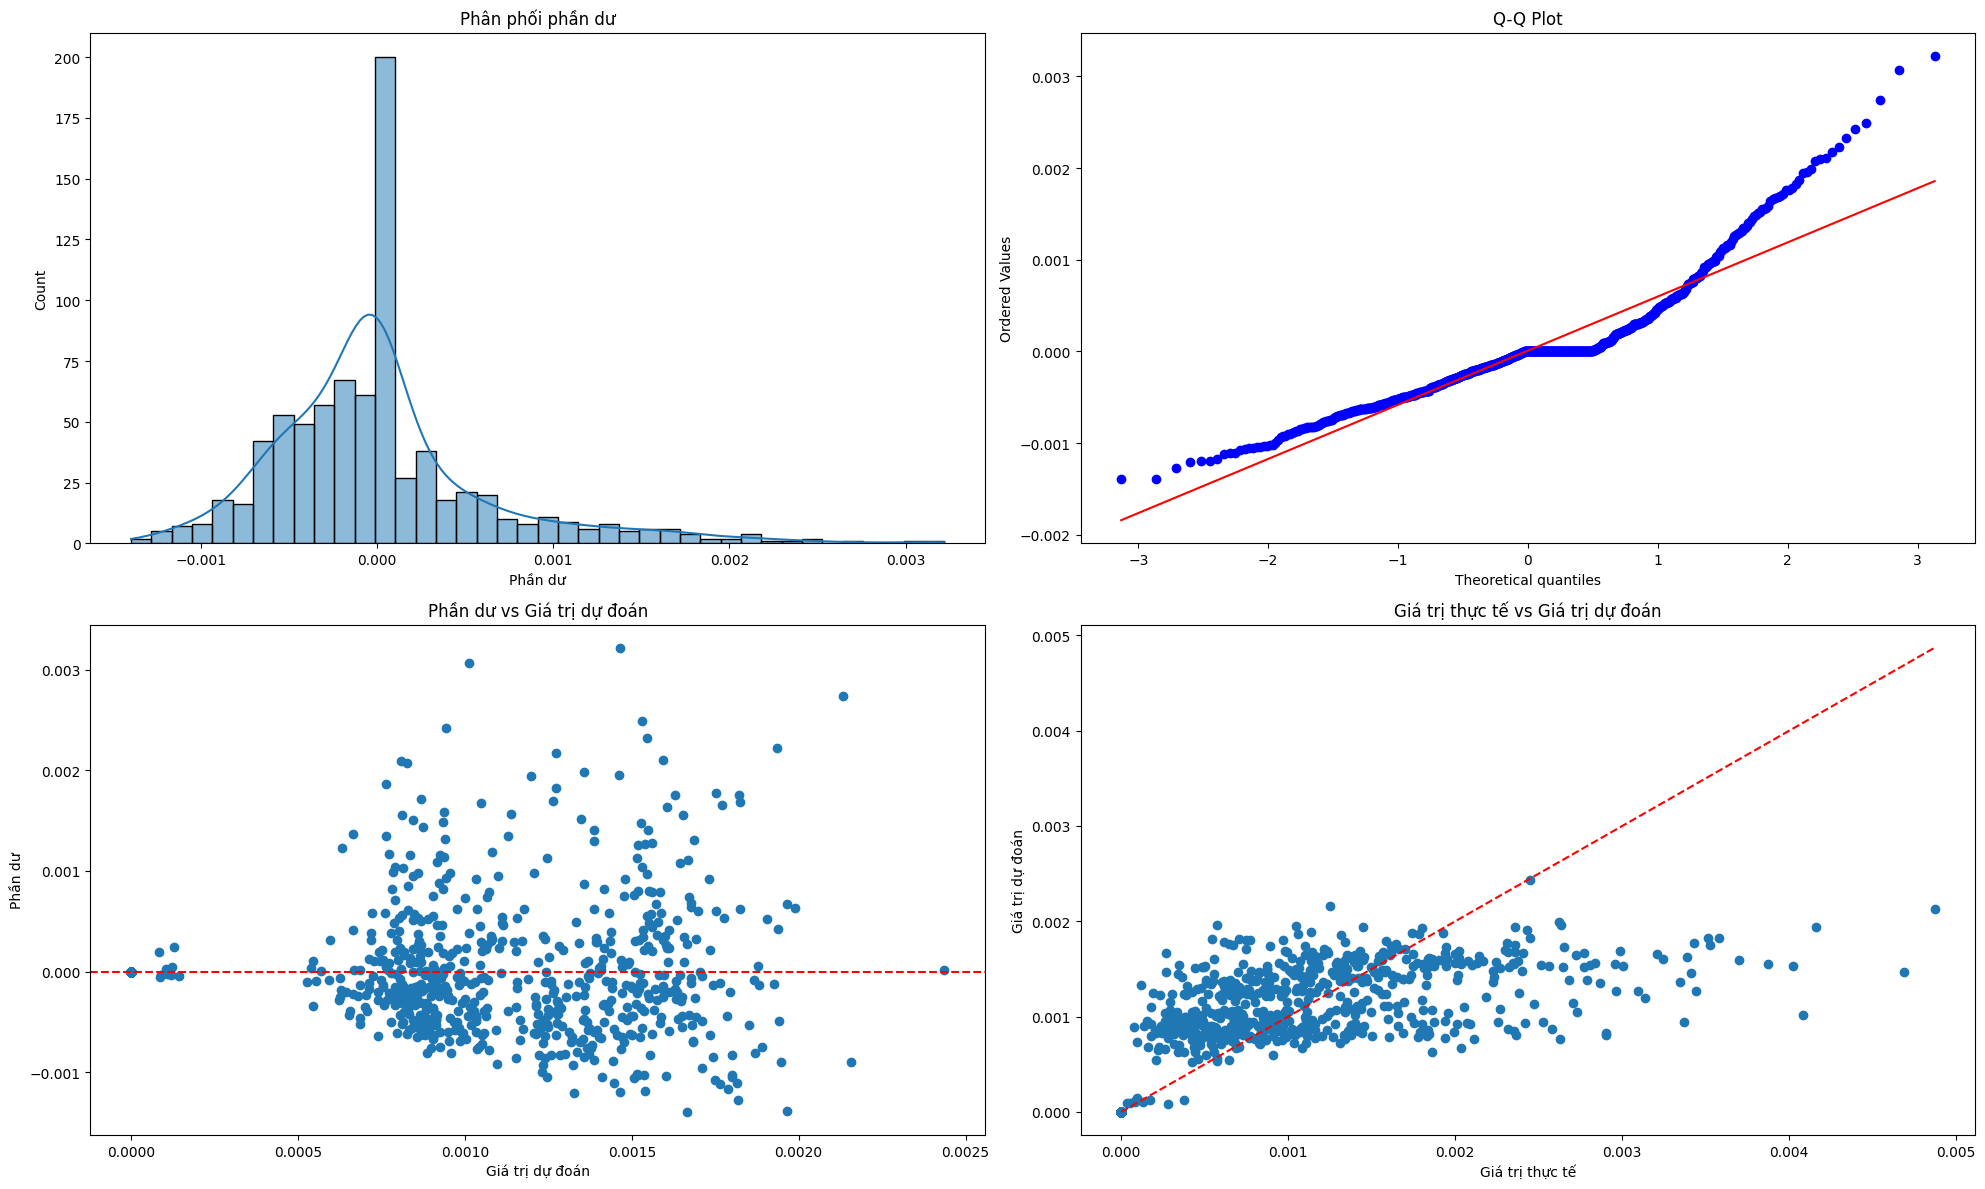

In [ ]:
plt.figure(figsize=(20, 12))
# 5.1. Phân phối phần dư
plt.subplot(2, 2, 1)
sns.histplot(residuals, kde=True)
plt.title('Phân phối phần dư')
plt.xlabel('Phần dư')

# 5.2. Q-Q plot
plt.subplot(2, 2, 2)
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot')

# 5.3. Scatter plot phần dư vs giá trị dự đoán
plt.subplot(2, 2, 3)
plt.scatter(y_pred, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Phần dư vs Giá trị dự đoán')
plt.xlabel('Giá trị dự đoán')
plt.ylabel('Phần dư')

# 5.4. Scatter plot giá trị thực tế vs giá trị dự đoán
plt.subplot(2, 2, 4)
plt.scatter(y_test, y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title('Giá trị thực tế vs Giá trị dự đoán')
plt.xlabel('Giá trị thực tế')
plt.ylabel('Giá trị dự đoán')

plt.tight_layout()
plt.show()

In [ ]:
print(f"Shape của X_test_final: {X_test_final.shape}")
print(f"Shape của y_test: {y_test.shape}")

Shape của X_test_final: (797, 146)
Shape của y_test: (797,)


In [ ]:
from statsmodels.stats.outliers_influence import OLSInfluence
import statsmodels.api as sm
# 6. Kiểm tra ảnh hưởng của các điểm ngoại lai

# Reset index để đảm bảo khớp
X = X_test_final.reset_index(drop=True)
y = y_test.reset_index(drop=True)

# Fit model
model = sm.OLS(y, sm.add_constant(X)).fit()

# Cook's Distance
influence = OLSInfluence(model)
cooks_d = influence.cooks_distance[0]

# In ra các điểm có ảnh hưởng mạnh
threshold = 4 / len(y)
influential_points = np.where(cooks_d > threshold)[0]

print("\n=== Cook's Distance ===")
print(f"Số điểm có Cook's D > 4/n: {len(influential_points)}")
print("Chỉ số các điểm ngoại lai tiềm năng:", influential_points)


# 7. Kiểm định tính phù hợp tổng thể
print("\n=== F-test ===")
print(f"F-statistic: {model.fvalue:.4f}")
print(f"p-value: {model.f_pvalue:.4f}")
print(f"Kết luận: {'Mô hình có ý nghĩa' if model.f_pvalue < 0.05 else 'Mô hình không có ý nghĩa'}")


=== Cook's Distance ===
Số điểm có Cook's D > 4/n: 30
Chỉ số các điểm ngoại lai tiềm năng: [  5  12  22  25  44  95 106 186 195 223 263 273 287 297 300 384 446 460
 468 471 522 528 530 540 555 612 619 733 777 784]

=== F-test ===
F-statistic: 1.4101
p-value: 0.0224
Kết luận: Mô hình có ý nghĩa


/usr/local/lib/python3.11/dist-packages/statsmodels/stats/outliers_influence.py:847: RuntimeWarning: invalid value encountered in sqrt
  return self.resid / sigma / np.sqrt(1 - hii)
/usr/local/lib/python3.11/dist-packages/statsmodels/stats/outliers_influence.py:867: RuntimeWarning: divide by zero encountered in divide
  cooks_d2 *= hii / (1 - hii)


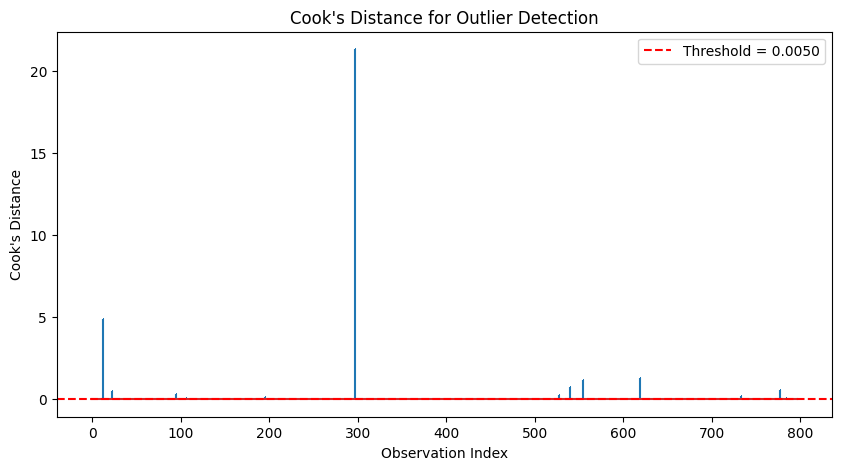

In [ ]:
plt.figure(figsize=(10, 5))
plt.stem(np.arange(len(cooks_d)), cooks_d, markerfmt=",")
plt.axhline(y=threshold, color='r', linestyle='--', label=f'Threshold = {threshold:.4f}')
plt.xlabel("Observation Index")
plt.ylabel("Cook's Distance")
plt.title("Cook's Distance for Outlier Detection")
plt.legend()
plt.show()

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
# 8. Kiểm tra tính ổn định của mô hình (Model Stability)
# Khởi tạo mô hình Random Forest
rf_model = RandomForestRegressor(random_state=42)

# Cross-validation với scoring là R²
scores_r2 = cross_val_score(rf_model, X_test_final, y_test, cv=5, scoring='r2')

print("\n=== K-fold Cross-Validation (R²) ===")
print(f"R² scores: {scores_r2}")
print(f"Mean R²: {np.mean(scores_r2):.4f}")
print(f"Std R²: {np.std(scores_r2):.4f}")


# Tự định nghĩa scorer tính RMSE
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Tạo RMSE scorer đúng cách
rmse_scorer = make_scorer(rmse, greater_is_better=False)  # Đảo dấu vì RMSE càng thấp càng tốt

scores_rmse = cross_val_score(rf_model, X_test_final, y_test, cv=5, scoring=rmse_scorer)

print("\n=== K-fold Cross-Validation (RMSE) ===")
print(f"RMSE scores: {-scores_rmse}")  # Đảo lại dấu để hiện giá trị dương
print(f"Mean RMSE: {-np.mean(scores_rmse):.4f}")
print(f"Std RMSE: {np.std(scores_rmse):.4f}")


=== K-fold Cross-Validation (R²) ===
R² scores: [-0.01387399 -0.16562866 -0.18850169 -0.15866648 -0.32647444]
Mean R²: -0.1706
Std R²: 0.0993

=== K-fold Cross-Validation (RMSE) ===
RMSE scores: [0.00090909 0.00097669 0.00086327 0.00093225 0.000885  ]
Mean RMSE: 0.0009
Std RMSE: 0.0000


In [ ]:
# 9. Kiểm tra tính quan trọng của các biến (Feature Importance)
# Huấn luyện mô hình Random Forest
kd = RandomForestRegressor(n_estimators=100, random_state=42)
kd.fit(X_test_final, y_test)

feature_names = X_test_final.columns
# Lấy điểm tầm quan trọng
importances = kd.feature_importances_
feature_importance = pd.DataFrame({
    'Đặc trưng': feature_names,
    'Tầm quan trọng': importances
}).sort_values(by='Tầm quan trọng', ascending=False)
print("\n=== Tầm quan trọng của các biến ===")
print(feature_importance)


=== Tầm quan trọng của các biến ===
                   Đặc trưng  Tầm quan trọng
142    tfidf_Carlo_Ancelotti        0.523275
145            tfidf_bán_dẫn        0.211549
143              tfidf_Tesla        0.088912
144     tfidf_Tín_chỉ_carbon        0.061799
37            posted_hour_20        0.023649
..                       ...             ...
118  tfidf_iPhone_16_Pro_Max        0.000000
135            tfidf_đấu_giá        0.000000
132       tfidf_Tiểu_Long_Nữ        0.000000
141         tfidf_thương_mại        0.000000
140          tfidf_hỗn_chiến        0.000000

[146 rows x 2 columns]


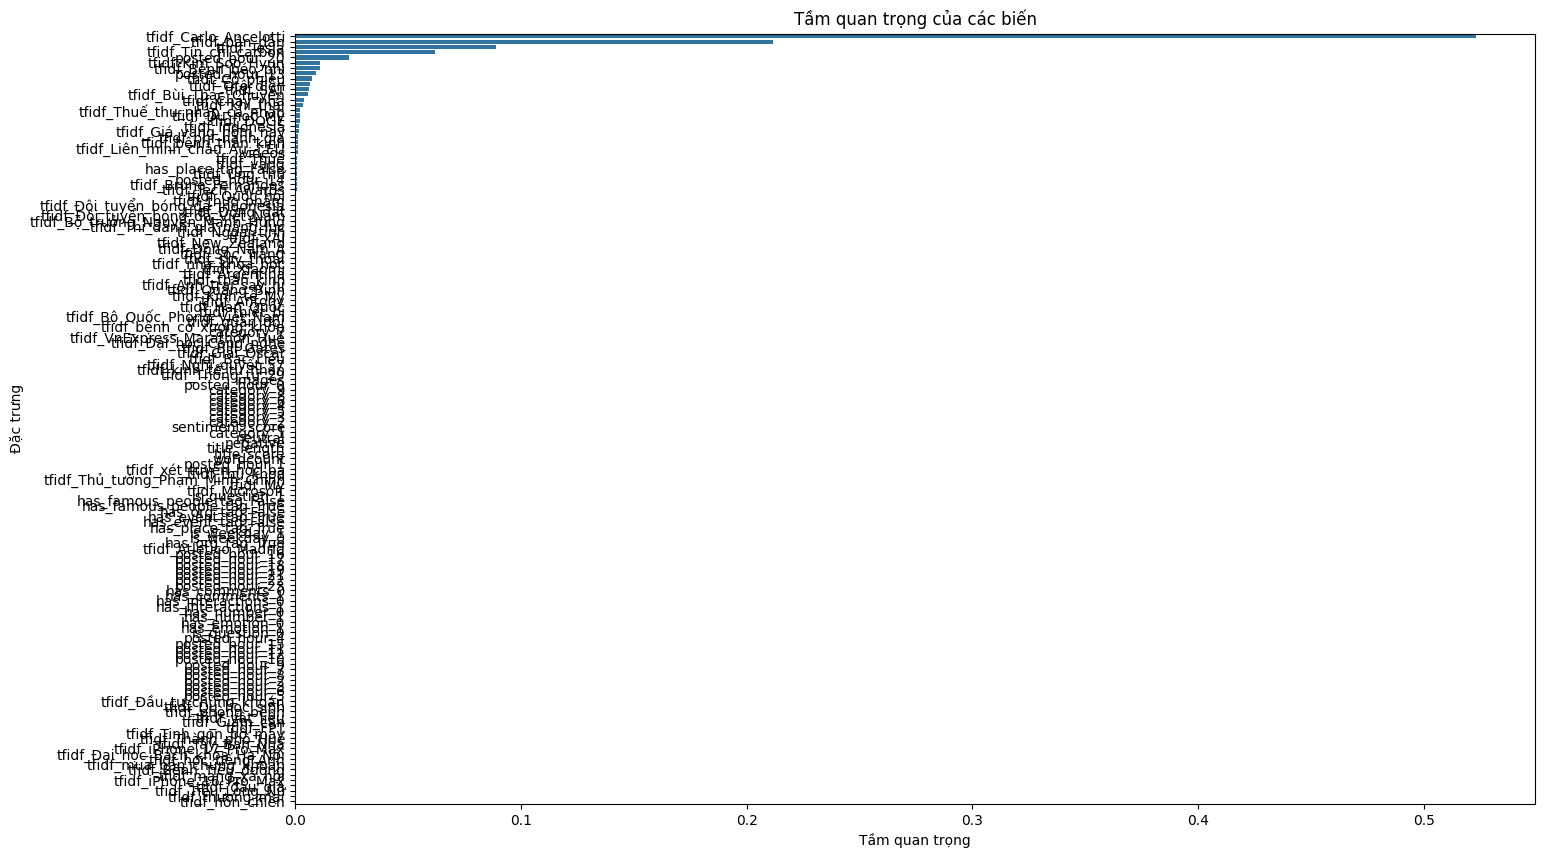

In [ ]:
plt.figure(figsize=(16, 10))
sns.barplot(x='Tầm quan trọng', y='Đặc trưng', data=feature_importance)
plt.title('Tầm quan trọng của các biến')
plt.show()

In [ ]:
# 10. Kiểm định với dữ liệu nhiêu
X_test_noisy = X_test_final + np.random.normal(0, 0.1, X_test_final.shape)
y_pred_noisy = kd.predict(X_test_noisy)
rmse_noisy = np.sqrt(mean_squared_error(y_test, y_pred_noisy))
print(f"\n=== Sensitivity Analysis ===")
print(f"RMSE với dữ liệu nhiễu: {rmse_noisy:.4f}")


=== Sensitivity Analysis ===
RMSE với dữ liệu nhiễu: 0.0007


In [ ]:
# 11. In thêm các metric đánh giá
print("\n=== CÁC METRIC ĐÁNH GIÁ MÔ HÌNH ===")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.4f}")
print(f"R²: {r2_score(y_test, y_pred_xgb):.4f}")
print(f"MAE: {np.mean(np.abs(residuals)):.4f}")
print(f"MAPE: {np.mean(np.abs(residuals / y_test)) * 100:.2f}%")
print(f"Giải thích phương sai: {np.var(y_pred) / np.var(y_test):.4f}")


=== CÁC METRIC ĐÁNH GIÁ MÔ HÌNH ===
RMSE: 0.0006
R²: 0.4452
MAE: 0.0004
MAPE: 67.60%
Giải thích phương sai: 0.4543


## ERROR ANALYSIS

In [ ]:
print(df.columns)

Index(['title', 'date', 'wordcount', 'comments', 'interactions', 'images',
       'videos', 'tags', 'category', 'popularity_score', 'title_length',
       'has_number', 'has_emotion', 'is_question', 'title_score',
       'sentiment_score', 'positive', 'negative', 'neutral', 'posted_hour',
       'is_weekday', 'classified_tags', 'has_famous_people_tag',
       'has_place_tag', 'has_event_tag', 'has_org_tag', 'has_comments',
       'has_interactions'],
      dtype='object')


In [ ]:
df1 = df

In [ ]:
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import numpy as np
import pandas as pd

# Log-transform target
y_train_log = np.log1p(y_train)
y_dev_log = np.log1p(y_dev)  # Dùng cho so sánh & đảo ngược

# K-Fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Các mô hình và grid parameters
models = {
    'XGBoost Regressor': {
        'estimator': XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=-1),
        'param_grid': {
            'n_estimators': [100, 200],
            'max_depth': [3, 5, 7],
            'learning_rate': [0.01, 0.1, 0.2]
        }
    },
    'Ridge Regression': {
        'estimator': Ridge(),
        'param_grid': {'alpha': [0.01, 0.1, 1, 10, 100]}
    },
    'Random Forest Regressor': {
        'estimator': RandomForestRegressor(random_state=42),
        'param_grid': {
            'n_estimators': [100, 200],
            'max_depth': [5, 7, 10],
            'min_samples_split': [2, 5]
        }
    }
}

best_models = {}
results = {}
error_dfs = []

for model_name, config in models.items():
    print(f"\n--- Huấn luyện {model_name} ---")

    grid = GridSearchCV(
        estimator=config['estimator'],
        param_grid=config['param_grid'],
        scoring='neg_mean_squared_error',
        cv=kf,
        verbose=1,
        n_jobs=-1
    )

    # Huấn luyện trên log(target)
    grid.fit(X_train_combined, y_train_log)
    best_model = grid.best_estimator_
    best_models[model_name] = best_model

    # Dự đoán trên log-scale
    y_dev_pred_log = best_model.predict(X_dev_combined)

    # Đảo log-transform
    y_dev_pred = np.expm1(y_dev_pred_log)
    y_dev_true = np.expm1(y_dev_log)

    # Tính RMSE và R² trên dữ liệu gốc
    dev_mse = mean_squared_error(y_dev_true, y_dev_pred)
    dev_rmse = np.sqrt(dev_mse) # Calculate RMSE by taking the square root of MSE

    dev_r2 = r2_score(y_dev_true, y_dev_pred)

    results[model_name] = {
        'dev_rmse': dev_rmse,
        'dev_r2': dev_r2
    }

    print(f"Best parameters ({model_name}): {grid.best_params_}")
    print(f"Best CV score (RMSE - log scale): {(-grid.best_score_)**0.5:.4f}")

    print(f"\n{model_name} (best parameters)")

    if model_name == 'Ridge Regression':
        print("Hệ số (cho các thành phần chính):")
        if hasattr(best_model, 'coef_'):
            for i, coef in enumerate(best_model.coef_):
                print(f"  PC{i+1}: {coef:.4f}")
        else:
            print("  Không có hệ số (ví dụ: mô hình cây)")
    else:
        print("Độ quan trọng của các thành phần chính:")
        if hasattr(best_model, 'feature_importances_'):
            for i, importance in enumerate(best_model.feature_importances_):
                print(f"  PC{i+1}: {importance:.4f}")
        else:
            print("  Không có độ quan trọng đặc trưng (ví dụ: mô hình tuyến tính)")

    print("Dev set:")
    print(f"RMSE: {dev_rmse:.4f}")
    print(f"R²: {dev_r2:.4f}")

    # =========================
    # PHÂN TÍCH LỖI & LƯU CSV
    # =========================
    try:
        if 'ID' in X_dev.columns:
            dev_ids = X_dev['ID'].reset_index(drop=True)
        else:
            dev_ids = y_dev.index.to_series().reset_index(drop=True)

        df_error = pd.DataFrame({
            'ID': dev_ids,
            'y_true': y_dev_true.reset_index(drop=True),
            'y_pred': pd.Series(y_dev_pred),
            'error': pd.Series(y_dev_pred) - y_dev_true.reset_index(drop=True),
        })

        df_error['abs_error'] = np.abs(df_error['error'])
        df_error['model'] = model_name

        # Chuyển sparse -> dense nếu cần
        X_dev_dense = X_dev_combined.toarray() if hasattr(X_dev_combined, 'toarray') else X_dev_combined

        # Ghi lại thành phần PCA
        for i in range(X_dev_dense.shape[1]):
            df_error[f'PC{i+1}'] = X_dev_dense[:, i]

        # Lưu file lỗi
        csv_filename = f"errors_{model_name.replace(' ', '_').lower()}.csv"
        df_error.to_csv(csv_filename, index=False)
        print(f"✅ Đã lưu lỗi thành file: {csv_filename}")

        error_dfs.append(df_error)

    except Exception as e:
        print(f"⚠️ Lỗi khi xử lý và lưu df_error cho {model_name}: {e}")


--- Huấn luyện XGBoost Regressor ---
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best parameters (XGBoost Regressor): {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}
Best CV score (RMSE - log scale): 0.0007

XGBoost Regressor (best parameters)
Độ quan trọng của các thành phần chính:
  PC1: 0.0000
  PC2: 0.0000
  PC3: 0.0048
  PC4: 0.0000
  PC5: 0.0000
  PC6: 0.0000
  PC7: 0.0000
  PC8: 0.0000
  PC9: 0.0000
  PC10: 0.0000
  PC11: 0.0000
  PC12: 0.0000
  PC13: 0.0000
  PC14: 0.0000
  PC15: 0.0000
  PC16: 0.0000
  PC17: 0.0000
  PC18: 0.0000
  PC19: 0.0000
  PC20: 0.0000
  PC21: 0.0000
  PC22: 0.0022
  PC23: 0.0000
  PC24: 0.0000
  PC25: 0.0000
  PC26: 0.0000
  PC27: 0.0000
  PC28: 0.0000
  PC29: 0.0000
  PC30: 0.0000
  PC31: 0.0085
  PC32: 0.0000
  PC33: 0.0000
  PC34: 0.0000
  PC35: 0.0000
  PC36: 0.0000
  PC37: 0.0000
  PC38: 0.0024
  PC39: 0.0000
  PC40: 0.0000
  PC41: 0.0000
  PC42: 0.0000
  PC43: 0.0000
  PC44: 0.0000
  PC45: 0.0000
  PC46: 0.0000
  PC4

<ipython-input-39-1617033912>:127: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_error[f'PC{i+1}'] = X_dev_dense[:, i]
<ipython-input-39-1617033912>:127: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_error[f'PC{i+1}'] = X_dev_dense[:, i]
<ipython-input-39-1617033912>:127: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `new

✅ Đã lưu lỗi thành file: errors_xgboost_regressor.csv

--- Huấn luyện Ridge Regression ---
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best parameters (Ridge Regression): {'alpha': 10}
Best CV score (RMSE - log scale): 0.0007

Ridge Regression (best parameters)
Hệ số (cho các thành phần chính):
  PC1: 0.0000
  PC2: 0.0000
  PC3: 0.0000
  PC4: 0.0000
  PC5: 0.0000
  PC6: 0.0000
  PC7: 0.0000
  PC8: 0.0000
  PC9: 0.0000
  PC10: 0.0000
  PC11: 0.0000
  PC12: 0.0000
  PC13: 0.0000
  PC14: 0.0000
  PC15: 0.0001
  PC16: 0.0000
  PC17: 0.0000
  PC18: 0.0000
  PC19: 0.0000
  PC20: 0.0000
  PC21: 0.0000
  PC22: 0.0001
  PC23: 0.0000
  PC24: 0.0000
  PC25: 0.0000
  PC26: 0.0000
  PC27: 0.0000
  PC28: 0.0000
  PC29: 0.0000
  PC30: 0.0000
  PC31: 0.0004
  PC32: -0.0001
  PC33: 0.0000
  PC34: 0.0000
  PC35: 0.0000
  PC36: 0.0000
  PC37: 0.0000
  PC38: -0.0001
  PC39: 0.0000
  PC40: 0.0000
  PC41: 0.0000
  PC42: 0.0000
  PC43: 0.0000
  PC44: 0.0000
  PC45: 0.0000
  PC46: 0.0000
  PC4

<ipython-input-39-1617033912>:127: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_error[f'PC{i+1}'] = X_dev_dense[:, i]
<ipython-input-39-1617033912>:127: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_error[f'PC{i+1}'] = X_dev_dense[:, i]
<ipython-input-39-1617033912>:127: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `new

✅ Đã lưu lỗi thành file: errors_ridge_regression.csv

--- Huấn luyện Random Forest Regressor ---
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best parameters (Random Forest Regressor): {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 100}
Best CV score (RMSE - log scale): 0.0007

Random Forest Regressor (best parameters)
Độ quan trọng của các thành phần chính:
  PC1: 0.0000
  PC2: 0.0000
  PC3: 0.0001
  PC4: 0.0000
  PC5: 0.0000
  PC6: 0.0000
  PC7: 0.0000
  PC8: 0.0000
  PC9: 0.0000
  PC10: 0.0000
  PC11: 0.0000
  PC12: 0.0000
  PC13: 0.0000
  PC14: 0.0000
  PC15: 0.0010
  PC16: 0.0000
  PC17: 0.0000
  PC18: 0.0000
  PC19: 0.0000
  PC20: 0.0000
  PC21: 0.0000
  PC22: 0.0000
  PC23: 0.0000
  PC24: 0.0000
  PC25: 0.0000
  PC26: 0.0000
  PC27: 0.0000
  PC28: 0.0000
  PC29: 0.0000
  PC30: 0.0000
  PC31: 0.0059
  PC32: 0.0000
  PC33: 0.0000
  PC34: 0.0000
  PC35: 0.0000
  PC36: 0.0000
  PC37: 0.0000
  PC38: 0.0002
  PC39: 0.0000
  PC40: 0.0000
  PC41: 0.0000
  PC42

<ipython-input-39-1617033912>:127: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_error[f'PC{i+1}'] = X_dev_dense[:, i]
<ipython-input-39-1617033912>:127: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_error[f'PC{i+1}'] = X_dev_dense[:, i]
<ipython-input-39-1617033912>:127: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `new

✅ Đã lưu lỗi thành file: errors_random_forest_regressor.csv


In [ ]:
# In kết quả tổng hợp
print("\n--- Kết quả tổng hợp trên tập Dev ---")
for model_name, metrics in results.items():
    print(f"{model_name}: RMSE = {metrics['dev_rmse']:.4f}, R² = {metrics['dev_r2']:.4f}")


--- Kết quả tổng hợp trên tập Dev ---
XGBoost Regressor: RMSE = 0.0007, R² = 0.4300
Ridge Regression: RMSE = 0.0007, R² = 0.4244
Random Forest Regressor: RMSE = 0.0007, R² = 0.4285


In [ ]:
# Dùng mô hình tốt nhất từ GridSearch
xgb_model = best_models['XGBoost Regressor']
xgb_model.fit(X_train_combined, y_train)

# Dự đoán
y_pred_xgb = xgb_model.predict(X_test_combined)

# Đánh giá
print("XGBoost - RMSE:", mean_squared_error(y_test, y_pred_xgb)**0.5)
print("XGBoost - R2 score:", r2_score(y_test, y_pred_xgb))

# Dùng mô hình tốt nhất từ GridSearch
rf_model = best_models['Random Forest Regressor']
rf_model.fit(X_train_combined, y_train)

# Dự đoán
y_pred_rf = rf_model.predict(X_test_combined)

# Đánh giá
print("Random Forest - RMSE:", mean_squared_error(y_test, y_pred_rf)**0.5)
print("Random Forest - R2 score:", r2_score(y_test, y_pred_rf))

# Dùng mô hình tốt nhất từ GridSearch
rr_model = best_models['Ridge Regression']
rr_model.fit(X_train_combined, y_train)

# Dự đoán
y_pred_rr = rr_model.predict(X_test_combined)

# Đánh giá
print("Ridge Regression - RMSE:", mean_squared_error(y_test, y_pred_rr)**0.5)
print("Ridge Regression - R2 score:", r2_score(y_test, y_pred_rr))

XGBoost - RMSE: 0.0006355700460423184
XGBoost - R2 score: 0.44079885245545325
Random Forest - RMSE: 0.0006229371805749164
Random Forest - R2 score: 0.462807775748307
Ridge Regression - RMSE: 0.0006393020747475939
Ridge Regression - R2 score: 0.43421238104003024


In [ ]:
import os

# Liệt kê tất cả file trong thư mục hiện tại
for file in os.listdir():
    if file.endswith('.csv') and file.startswith('errors_'):
        print(file)

errors_xgboost_regressor.csv
errors_ridge_regression.csv
errors_random_forest_regressor.csv


In [ ]:
import os

# Tạo thư mục mới trên Google Drive nếu chưa có
save_dir = '/content/drive/MyDrive/DS_PROJECT/NLe\'s draft/vnexpress_errors_edited'
os.makedirs(save_dir, exist_ok=True)

import shutil

# Danh sách các file csv bạn đã lưu
csv_files = [
    'errors_xgboost_regressor.csv',
    'errors_ridge_regression.csv',
    'errors_random_forest_regressor.csv'
]

# Di chuyển từng file vào thư mục trên Drive
for file in csv_files:
    src = f'/content/{file}'  # vị trí hiện tại trong Colab
    dst = os.path.join(save_dir, file)  # vị trí trên Drive
    if os.path.exists(src):
        shutil.move(src, dst)
        print(f"Đã chuyển {file} vào Google Drive: {dst}")
    else:
        print(f"Không tìm thấy file: {file}")

Đã chuyển errors_xgboost_regressor.csv vào Google Drive: /content/drive/MyDrive/DS_PROJECT/NLe's draft/vnexpress_errors_edited/errors_xgboost_regressor.csv
Đã chuyển errors_ridge_regression.csv vào Google Drive: /content/drive/MyDrive/DS_PROJECT/NLe's draft/vnexpress_errors_edited/errors_ridge_regression.csv
Đã chuyển errors_random_forest_regressor.csv vào Google Drive: /content/drive/MyDrive/DS_PROJECT/NLe's draft/vnexpress_errors_edited/errors_random_forest_regressor.csv


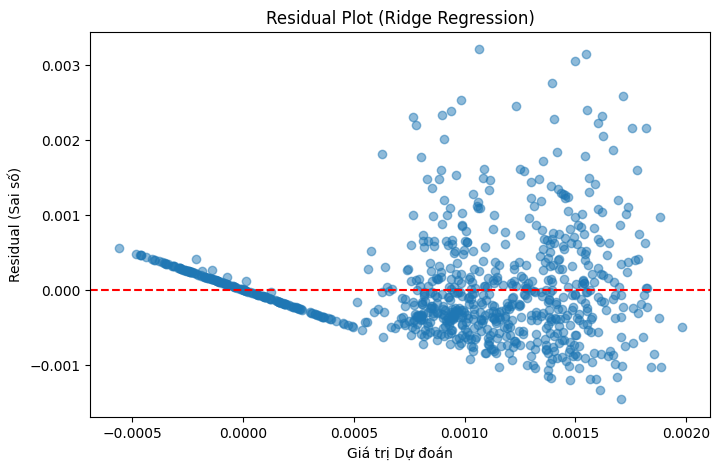

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Đọc file CSV
df = pd.read_csv('/content/drive/MyDrive/DS_PROJECT/NLe\'s draft/vnexpress_errors_edited/errors_ridge_regression.csv')

# Tính residual
y_true = df['y_true']
y_pred = df['y_pred']
residuals = y_true - y_pred

# Vẽ residual plot
plt.figure(figsize=(8, 5))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Giá trị Dự đoán')
plt.ylabel('Residual (Sai số)')
plt.title('Residual Plot (Ridge Regression)')
plt.show()

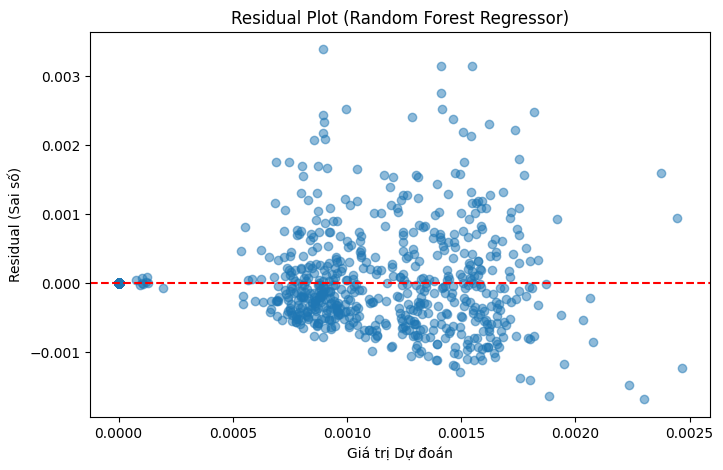

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Đọc file CSV
df = pd.read_csv('/content/drive/MyDrive/DS_PROJECT/NLe\'s draft/vnexpress_errors_edited/errors_random_forest_regressor.csv')

# Tính residual
y_true = df['y_true']
y_pred = df['y_pred']
residuals = y_true - y_pred

# Vẽ residual plot
plt.figure(figsize=(8, 5))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Giá trị Dự đoán')
plt.ylabel('Residual (Sai số)')
plt.title('Residual Plot (Random Forest Regressor)')
plt.show()

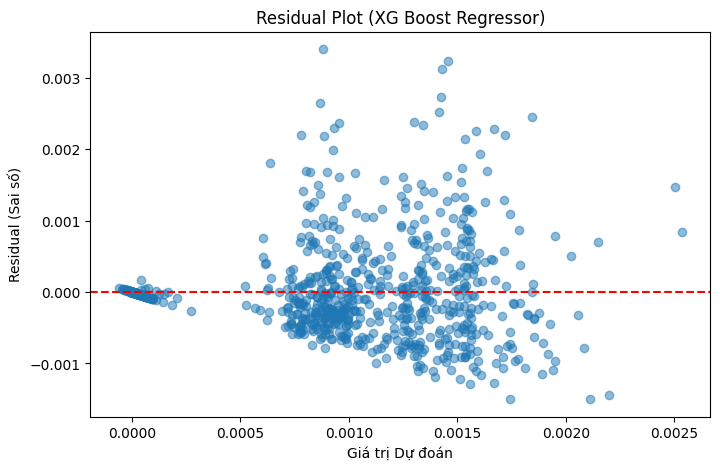

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Đọc file CSV
df = pd.read_csv('/content/drive/MyDrive/DS_PROJECT/NLe\'s draft/vnexpress_errors_edited/errors_xgboost_regressor.csv')

# Tính residual
y_true = df['y_true']
y_pred = df['y_pred']
residuals = y_true - y_pred

# Vẽ residual plot
plt.figure(figsize=(8, 5))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Giá trị Dự đoán')
plt.ylabel('Residual (Sai số)')
plt.title('Residual Plot (XG Boost Regressor)')
plt.show()

In [ ]:
import pandas as pd

#-----------------------
#   XGBoost Regressor
#-----------------------

# Đọc file lỗi từ mô hình
df_errors = pd.read_csv('/content/drive/MyDrive/DS_PROJECT/NLe\'s draft/vnexpress_errors_edited/errors_xgboost_regressor.csv')

# Tính độ sai số tuyệt đối
df_errors['abs_error'] = (df_errors['y_true'] - df_errors['y_pred']).abs()

# Chọn top-k lỗi lớn nhất
top_k = 20
df_top_errors = df_errors.sort_values(by='abs_error', ascending=False).head(top_k)

# Chọn các cột liên quan để phân tích
columns_needed = ['ID', 'y_true', 'y_pred', 'abs_error']
df_analysis = df_top_errors[columns_needed].copy()

# Thêm cột để ghi chú phân tích thủ công
df_analysis['note'] = ''  # Bạn có thể điền sau trong Excel/Google Sheets

# Lưu file CSV
df_analysis.to_csv('/content/drive/MyDrive/DS_PROJECT/NLe\'s draft/vnexpress_errors_edited/top20_xgboost.csv', index=False)

print("Đã lưu file phân tích lỗi top-k của XGBoost")

#-----------------------
#   Random Forest
#-----------------------

# Đọc file lỗi từ mô hình
df_errors = pd.read_csv('/content/drive/MyDrive/DS_PROJECT/NLe\'s draft/vnexpress_errors_edited/errors_random_forest_regressor.csv')

# Tính độ sai số tuyệt đối
df_errors['abs_error'] = (df_errors['y_true'] - df_errors['y_pred']).abs()

# Chọn top-k lỗi lớn nhất
top_k = 20
df_top_errors = df_errors.sort_values(by='abs_error', ascending=False).head(top_k)

# Chọn các cột liên quan để phân tích
columns_needed = ['ID', 'y_true', 'y_pred', 'abs_error']
df_analysis = df_top_errors[columns_needed].copy()

# Thêm cột để ghi chú phân tích thủ công
df_analysis['note'] = ''  # Bạn có thể điền sau trong Excel/Google Sheets

# Lưu file CSV
df_analysis.to_csv('/content/drive/MyDrive/DS_PROJECT/NLe\'s draft/vnexpress_errors_edited/top20_random_forest.csv', index=False)

print("Đã lưu file phân tích lỗi top-k của Random Forest")

#-----------------------
#  Ridge Regression
#-----------------------

# Đọc file lỗi từ mô hình
df_errors = pd.read_csv('/content/drive/MyDrive/DS_PROJECT/NLe\'s draft/vnexpress_errors_edited/errors_ridge_regression.csv')

# Tính độ sai số tuyệt đối
df_errors['abs_error'] = (df_errors['y_true'] - df_errors['y_pred']).abs()

# Chọn top-k lỗi lớn nhất
top_k = 20
df_top_errors = df_errors.sort_values(by='abs_error', ascending=False).head(top_k)

# Chọn các cột liên quan để phân tích
columns_needed = ['ID', 'y_true', 'y_pred', 'abs_error']
df_analysis = df_top_errors[columns_needed].copy()

# Thêm cột để ghi chú phân tích thủ công
df_analysis['note'] = ''  # Bạn có thể điền sau trong Excel/Google Sheets

# Lưu file CSV
df_analysis.to_csv('/content/drive/MyDrive/DS_PROJECT/NLe\'s draft/vnexpress_errors_edited/top20_ridge_reg.csv', index=False)

print("Đã lưu file phân tích lỗi top-k của Ridge Regression")

Đã lưu file phân tích lỗi top-k của XGBoost
Đã lưu file phân tích lỗi top-k của Random Forest
Đã lưu file phân tích lỗi top-k của Ridge Regression


In [ ]:
# GỘP DỮ LIỆU

import pandas as pd

# XGBOOST

# Đọc dữ liệu
df1 = pd.read_csv('/content/drive/MyDrive/DS_PROJECT/NLe\'s draft/dataset_trial.csv')
df2 = pd.read_csv('/content/drive/MyDrive/DS_PROJECT/NLe\'s draft/vnexpress_errors_edited/top20_xgboost.csv')

# Gộp dữ liệu: giữ toàn bộ df2, nối thêm thông tin từ df1 dựa trên cột 'ID'
merged_df = pd.merge(df2, df1, on='ID', how='left')

# Xuất ra file kết quả
merged_df.to_csv('/content/drive/MyDrive/DS_PROJECT/NLe\'s draft/vnexpress_errors_edited/xgboost_enriched.csv', index=False)

print("Đã gộp thông tin từ df1 vào df2 theo ID. File lưu: xgboost_enriched.csv")

# RANDOM FOREST

# Đọc dữ liệu
df1 = pd.read_csv('/content/drive/MyDrive/DS_PROJECT/NLe\'s draft/dataset_trial.csv')
df2 = pd.read_csv('/content/drive/MyDrive/DS_PROJECT/NLe\'s draft/vnexpress_errors_edited/top20_random_forest.csv')
# Gộp dữ liệu: giữ toàn bộ df2, nối thêm thông tin từ df1 dựa trên cột 'ID'
merged_df = pd.merge(df2, df1, on='ID', how='left')

# Xuất ra file kết quả
merged_df.to_csv('/content/drive/MyDrive/DS_PROJECT/NLe\'s draft/vnexpress_errors_edited/rf_enriched.csv', index=False)

print("Đã gộp thông tin từ df1 vào df2 theo ID. File lưu: rf_enriched.csv")

# RIDGE REGRESSION

# Đọc dữ liệu
df1 = pd.read_csv('/content/drive/MyDrive/DS_PROJECT/NLe\'s draft/dataset_trial.csv')
df2 = pd.read_csv('/content/drive/MyDrive/DS_PROJECT/NLe\'s draft/vnexpress_errors_edited/top20_ridge_reg.csv')
# Gộp dữ liệu: giữ toàn bộ df2, nối thêm thông tin từ df1 dựa trên cột 'ID'
merged_df = pd.merge(df2, df1, on='ID', how='left')

# Xuất ra file kết quả
merged_df.to_csv('/content/drive/MyDrive/DS_PROJECT/NLe\'s draft/vnexpress_errors_edited/ridge_enriched.csv', index=False)

print("Đã gộp thông tin từ df1 vào df2 theo ID. File lưu: ridge_enriched.csv")

Đã gộp thông tin từ df1 vào df2 theo ID. File lưu: xgboost_enriched.csv
Đã gộp thông tin từ df1 vào df2 theo ID. File lưu: rf_enriched.csv
Đã gộp thông tin từ df1 vào df2 theo ID. File lưu: ridge_enriched.csv


XGBOOST

In [ ]:
from xgboost import XGBRegressor

kf = KFold(n_splits=5, shuffle=True, random_state=42)

rmse_list = []
r2_list = []

fold = 1
for train_idx, val_idx in kf.split(X_train_combined):
    X_tr, X_val = X_train_combined[train_idx], X_train_combined[val_idx]
    y_tr, y_val = y_train[train_idx], y_train[val_idx]

    model = XGBRegressor(
        n_estimators=100,
        max_depth=5,
        learning_rate=0.1,
        subsample=0.8,
        random_state=42,
    )

    model.fit(X_tr, y_tr)
    y_val_pred = model.predict(X_val)

    rmse = mean_squared_error(y_val, y_val_pred)**0.5
    r2 = r2_score(y_val, y_val_pred)

    rmse_list.append(rmse)
    r2_list.append(r2)

    print(f"📘 Fold {fold}: RMSE = {rmse:.4f} | R² = {r2:.4f}")
    fold += 1

# Tổng kết sau các fold
print("\n📊 Trung bình các fold:")
print(f"RMSE: {np.mean(rmse_list):.4f} ± {np.std(rmse_list):.4f}")
print(f"R²:   {np.mean(r2_list):.4f} ± {np.std(r2_list):.4f}")

📘 Fold 1: RMSE = 0.0007 | R² = 0.4519
📘 Fold 2: RMSE = 0.0007 | R² = 0.4299
📘 Fold 3: RMSE = 0.0007 | R² = 0.3896
📘 Fold 4: RMSE = 0.0007 | R² = 0.4360
📘 Fold 5: RMSE = 0.0006 | R² = 0.4113

📊 Trung bình các fold:
RMSE: 0.0007 ± 0.0000
R²:   0.4237 ± 0.0214


In [ ]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score # Import necessary metrics if not already imported

# Instantiate the model with the chosen parameters
# (Replace with your best model if you used GridSearchCV to find better ones)
model = XGBRegressor(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    subsample=0.8,
    random_state=42,
)

# Fit the model on the combined training data (PCA + BoW)
model.fit(X_train_combined, y_train)

# Predict on the combined test data (PCA + BoW)
y_pred_test = model.predict(X_test_combined) # Use a new variable name for clarity

# Evaluate the model on the test set (optional, but good practice)
test_rmse = mean_squared_error(y_test, y_pred_test)**0.5
test_r2 = r2_score(y_test, y_pred_test)
print(f"\n--- Kết quả trên tập Test (XGBoost) ---")
print(f"RMSE: {test_rmse:.4f}")
print(f"R²: {test_r2:.4f}")


# Lấy ID từ tập test (nếu có)
if 'ID' in X_test.columns:
    test_ids = X_test['ID'].reset_index(drop=True)
else:
    # Nếu không có ID, sử dụng index của y_test
    test_ids = y_test.index.to_series().reset_index(drop=True)

# Tạo DataFrame phân tích lỗi, sử dụng y_pred_test mới
df_test_error = pd.DataFrame({
    'ID': test_ids,
    'y_true': y_test.reset_index(drop=True),
    'y_pred': pd.Series(y_pred_test, index=test_ids.index), # Đảm bảo index khớp
    'error': pd.Series(y_pred_test, index=test_ids.index) - y_test.reset_index(drop=True),
})

# Tính sai số tuyệt đối
df_test_error['abs_error'] = df_test_error['error'].abs()

X_test_dense = X_test_combined.toarray()  # Chuyển sang numpy array

for i in range(X_test_dense.shape[1]):
    df_test_error[f'PC{i+1}'] = pd.Series(X_test_dense[:, i], index=test_ids.index)

df1 = pd.read_csv('/content/drive/MyDrive/DS_PROJECT/NLe\'s draft/dataset_trial.csv')

# Merge metadata để phân tích sâu hơn
df_test_error = df_test_error.merge(df1, on='ID', how='left')

# Lưu file CSV
df_test_error.to_csv("/content/drive/MyDrive/DS_PROJECT/NLe\'s draft/vnexpress_errors_edited/errors_test_xgboost.csv", index=False)
print("✅ Đã lưu lỗi tập test vào: errors_test_xgboost.csv")


--- Kết quả trên tập Test (XGBoost) ---
RMSE: 0.0006
R²: 0.4498


<ipython-input-61-1688418283>:49: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_test_error[f'PC{i+1}'] = pd.Series(X_test_dense[:, i], index=test_ids.index)
<ipython-input-61-1688418283>:49: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_test_error[f'PC{i+1}'] = pd.Series(X_test_dense[:, i], index=test_ids.index)
<ipython-input-61-1688418283>:49: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at o

✅ Đã lưu lỗi tập test vào: errors_test_xgboost.csv


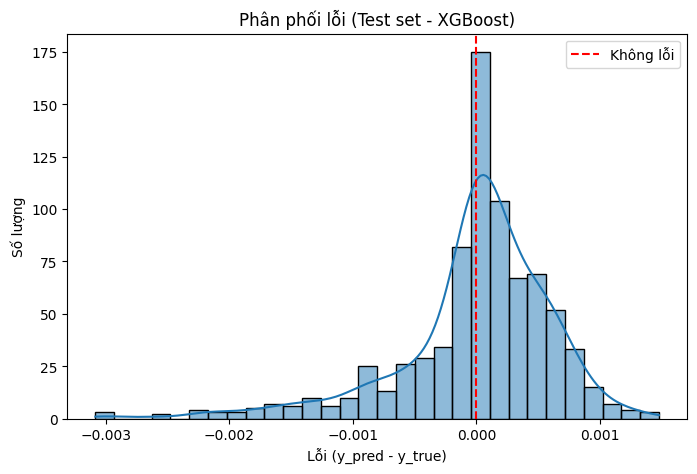

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
sns.histplot(df_test_error['error'], bins=30, kde=True)
plt.title("Phân phối lỗi (Test set - XGBoost)")
plt.xlabel("Lỗi (y_pred - y_true)")
plt.ylabel("Số lượng")
plt.axvline(0, color='red', linestyle='--', label='Không lỗi')
plt.legend()
plt.show()

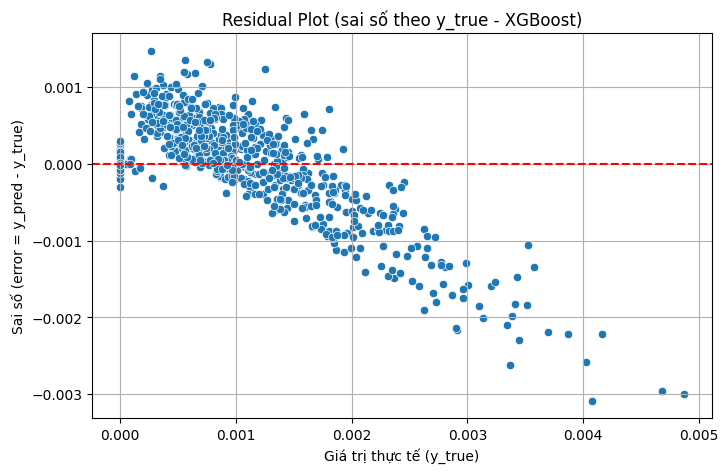

In [ ]:
plt.figure(figsize=(8, 5))
sns.scatterplot(x='y_true', y='error', data=df_test_error)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residual Plot (sai số theo y_true - XGBoost)")
plt.xlabel("Giá trị thực tế (y_true)")
plt.ylabel("Sai số (error = y_pred - y_true)")
plt.grid(True)
plt.show()

RANDOM FOREST

📘 Fold 1: RMSE = 0.0007 | R² = 0.4546
📘 Fold 2: RMSE = 0.0007 | R² = 0.4318
📘 Fold 3: RMSE = 0.0007 | R² = 0.3935
📘 Fold 4: RMSE = 0.0007 | R² = 0.4452
📘 Fold 5: RMSE = 0.0006 | R² = 0.4222

📊 Trung bình các fold:
RMSE: 0.0007 ± 0.0000
R²:   0.4295 ± 0.0211

--- Kết quả trên tập Test (Random Forest) ---
RMSE: 0.0006
R²: 0.4662


<ipython-input-59-2683171555>:78: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_test_error[f'PC{i+1}'] = pd.Series(X_test_dense[:, i], index=test_ids.index)
<ipython-input-59-2683171555>:78: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_test_error[f'PC{i+1}'] = pd.Series(X_test_dense[:, i], index=test_ids.index)
<ipython-input-59-2683171555>:78: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at o

✅ Đã lưu lỗi tập test vào: errors_test_rf.csv


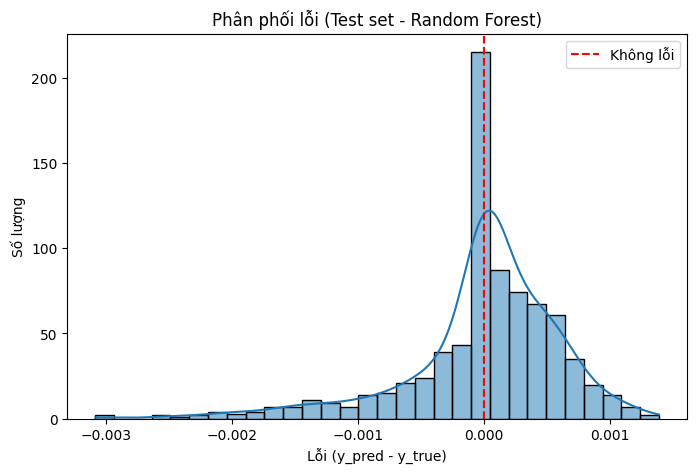

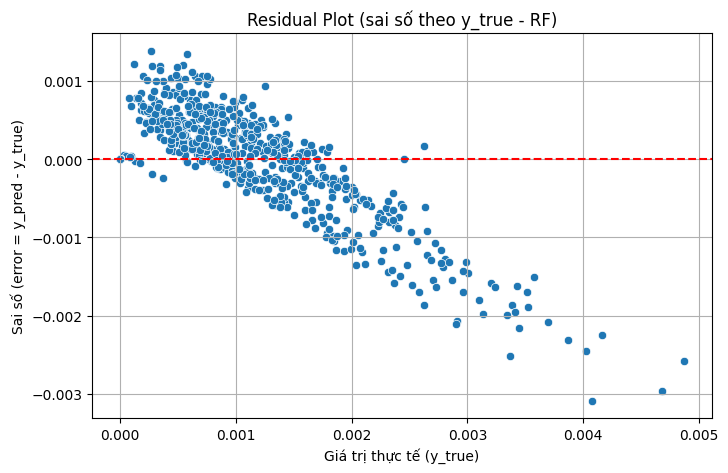

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# === CROSS-VALIDATION ===
kf = KFold(n_splits=5, shuffle=True, random_state=42)
rmse_list = []
r2_list = []

fold = 1
for train_idx, val_idx in kf.split(X_train_combined):
    X_tr, X_val = X_train_combined[train_idx], X_train_combined[val_idx]
    y_tr, y_val = y_train[train_idx], y_train[val_idx]

    model = RandomForestRegressor(
        n_estimators=100,
        max_depth=10,
        random_state=42,
        n_jobs=-1,
    )

    model.fit(X_tr, y_tr)
    y_val_pred = model.predict(X_val)

    rmse = mean_squared_error(y_val, y_val_pred)**0.5
    r2 = r2_score(y_val, y_val_pred)

    rmse_list.append(rmse)
    r2_list.append(r2)

    print(f"📘 Fold {fold}: RMSE = {rmse:.4f} | R² = {r2:.4f}")
    fold += 1

# Tổng kết CV
print("\n📊 Trung bình các fold:")
print(f"RMSE: {np.mean(rmse_list):.4f} ± {np.std(rmse_list):.4f}")
print(f"R²:   {np.mean(r2_list):.4f} ± {np.std(r2_list):.4f}")

# === TRAIN ON FULL DATA ===
model = RandomForestRegressor(
    n_estimators=100,
    max_depth=10,
    random_state=42,
    n_jobs=-1,
)
model.fit(X_train_combined, y_train)

y_pred_test = model.predict(X_test_combined)
test_rmse = mean_squared_error(y_test, y_pred_test)**0.5
test_r2 = r2_score(y_test, y_pred_test)
print(f"\n--- Kết quả trên tập Test (Random Forest) ---")
print(f"RMSE: {test_rmse:.4f}")
print(f"R²: {test_r2:.4f}")

# === PHÂN TÍCH LỖI ===
if 'ID' in X_test.columns:
    test_ids = X_test['ID'].reset_index(drop=True)
else:
    test_ids = y_test.index.to_series().reset_index(drop=True)

df_test_error = pd.DataFrame({
    'ID': test_ids,
    'y_true': y_test.reset_index(drop=True),
    'y_pred': pd.Series(y_pred_test, index=test_ids.index),
    'error': pd.Series(y_pred_test, index=test_ids.index) - y_test.reset_index(drop=True),
})
df_test_error['abs_error'] = df_test_error['error'].abs()

# Convert sparse to dense for column extraction
X_test_dense = X_test_combined.toarray()

# Add PC1 to PCn columns (dùng luôn toàn bộ feature từ PCA + BoW)
for i in range(X_test_dense.shape[1]):
    df_test_error[f'PC{i+1}'] = pd.Series(X_test_dense[:, i], index=test_ids.index)

# Merge metadata
df1 = pd.read_csv('/content/drive/MyDrive/DS_PROJECT/NLe\'s draft/dataset_trial.csv')
df_test_error = df_test_error.merge(df1, on='ID', how='left')

# Lưu file lỗi
df_test_error.to_csv("/content/drive/MyDrive/DS_PROJECT/NLe\'s draft/vnexpress_errors_edited/errors_test_rf.csv", index=False)
print("✅ Đã lưu lỗi tập test vào: errors_test_rf.csv")

# === VISUALIZATION ===
plt.figure(figsize=(8, 5))
sns.histplot(df_test_error['error'], bins=30, kde=True)
plt.title("Phân phối lỗi (Test set - Random Forest)")
plt.xlabel("Lỗi (y_pred - y_true)")
plt.ylabel("Số lượng")
plt.axvline(0, color='red', linestyle='--', label='Không lỗi')
plt.legend()
plt.show()

plt.figure(figsize=(8, 5))
sns.scatterplot(x='y_true', y='error', data=df_test_error)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residual Plot (sai số theo y_true - RF)")
plt.xlabel("Giá trị thực tế (y_true)")
plt.ylabel("Sai số (error = y_pred - y_true)")
plt.grid(True)
plt.show()